# By-phone error rates: TIMIT
This computes and compares error rates and confusion matrices at the phone level across different models' predicted transcriptions in the full TIMIT corpus. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.

In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phonecodes import phonecode_tables
import seaborn as sns

from multipa.evaluation import ModelEvaluator, PREDICTION_KEY, EPS, compute_error_rate_confidence_intervals_df
from multipa.visualization import plot_error_rates_by_phone_and_model, plot_token_confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

TOKEN_ANALYSIS_OUTPUT = "timit_token_analysis.csv"
DETAILED_EVAL_PATH = Path("../../data/timit_results/detailed_predictions/")
# These are the models we're actually interested in evaluating in detail
DETAILED_EVAL_CSVS = [
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Third party comparison models
    "openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    #"facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_detailed_predictions.csv",
]

REFERENCE_COL = "ipa"

VALID_TIMIT_PHONES = set(phonecode_tables._timit2ipa.values()) - set(phonecode_tables._tone2ipa["eng"].values())

TIMIT_VOWELS = set(["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɹ̩"])
TIMIT_DIPHTHONGS = set(["aʊ", "eɪ", "aɪ", "oʊ", "ɔɪ"])

# This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
ALL_TIMIT_VOWELS = TIMIT_VOWELS | TIMIT_DIPHTHONGS

TIMIT_CONSONANTS = VALID_TIMIT_PHONES - ALL_TIMIT_VOWELS

# Use to clean up issues in the original TIMIT to IPA conversion
POST_PROC_MAP = {
    "ɝ": "ɹ̩",
    "g": "ɡ",
    "ŋ̍": "ŋ̩"
}

# I'm just being picky about plot colors
HUE_ORDER = ["full_dataset_train",
"excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k", "openai_whisper-medium.en_to_epitran", "allosaurus_eng2102_eng", "facebook_wav2vec2-lv-60-espeak-cv-ft", "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns"]

HUE_ORDER_INDEX = {key: i for i, key in enumerate(HUE_ORDER)}

PALETTE = "colorblind"

sns.set_palette(PALETTE)

def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for tokenization convenience
timit_merge_func = lambda x,y: diphthong_merge(x, y, VALID_TIMIT_PHONES)

def get_model_group(model_name):
    for p in ["train_duration_20000_samples", "full_dataset_train"]:
        if model_name.startswith(p):
            return p
    return model_name

def timit_ipa_post_process(timit_ipa):
    final_ipa = timit_ipa
    for k, v in POST_PROC_MAP.items():
        final_ipa = final_ipa.replace(k, v)
    return final_ipa



/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Post-process predictions and evaluations
Read in evaluation results, tokenize, and calculate token counts and edit distance errors for each model. 


In [2]:
# Read in model results and re-generate comparison metrics
MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":timit_merge_func})

# Will use to make a dataframe that we can pivot to compare model vocabulary by token counts
# in Buckeye test set predictions across models
model_token_counts = []
model_names = []

for csv in DETAILED_EVAL_CSVS:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()
    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    # Clean up issues with original pandas conversion
    model_results[REFERENCE_COL] = model_results[REFERENCE_COL].apply(timit_ipa_post_process)
    model_names.append(model_name)
    latest_ref_col = model_results[REFERENCE_COL]
    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)

    model_token_counts.extend([(model_name, t, c) for t,c in MODEL_EVALUATOR._true_token_counts[model_name].items()])

model_token_counts_df = pd.DataFrame(model_token_counts, columns=["model_name", "token", "count"])

Processing ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv
Processing openai_whisper-medium.en_to_epitran_detailed_predictions.csv
Processing allosaurus_eng2102_eng_detailed_predictions.csv
Processing facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv
Processing ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv
Processing excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_detailed_predictions.csv


In [3]:
display(model_token_counts_df.head())
display(model_token_counts_df.tail())

model_name token  count
0  full_dataset_train_3     ʃ   2972
1  full_dataset_train_3     u    725
2  full_dataset_train_3     w   4379
3  full_dataset_train_3     ə   4956
4  full_dataset_train_3     z   5046

model_name token  count
371  excalibur12_wav2vec2-large-lv60_phoneme-timit_...    ə̥    493
372  excalibur12_wav2vec2-large-lv60_phoneme-timit_...    ɾ̃   1331
373  excalibur12_wav2vec2-large-lv60_phoneme-timit_...     ʒ    222
374  excalibur12_wav2vec2-large-lv60_phoneme-timit_...     H    130
375  excalibur12_wav2vec2-large-lv60_phoneme-timit_...    ŋ̩     43

In [4]:
# Sanity check token counts in the gold-standard labels against actual vocabulary
# The invalid token warnings are harmless, it's just removing some "NOISE" and disfluency markers that snuck through
# data preprocessing, but don't affect training
final_token_counts = {t:0 for t in VALID_TIMIT_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref, diphthongs=True, merge = timit_merge_func))


test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_TIMIT_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

display(token_counts_df.head())
display(token_counts_df.tail())

REMOVING INVALID TOKEN: H b'H'


phone  counts
0      ɨ   11587
17     s   10114
7      i    9663
41     n    9569
13     ɹ    9064

phone  counts
9      u     725
47    ə̥     493
24     ʒ     222
34    m̩     171
33    ŋ̩      43

In [5]:
# Munge data into dataframe format for analysis
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_TIMIT_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

all_error_rates_df = compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")
all_error_rates_df = all_error_rates_df.sort_values("counts", ascending=False)

In [6]:
display(all_error_rates_df.head())
display(all_error_rates_df.tail())

model_name phone  err_rate  \
63                      full_dataset_train_3     ɨ       1.0   
64  openai_whisper-large-v3-turbo_to_epitran     ɨ       1.0   
65       openai_whisper-medium.en_to_epitran     ɨ       1.0   
66                    allosaurus_eng2102_eng     ɨ       1.0   
67      facebook_wav2vec2-lv-60-espeak-cv-ft     ɨ       1.0   

                                 model_group  counts  confidence_interval  
63                        full_dataset_train   11587                  0.0  
64  openai_whisper-large-v3-turbo_to_epitran   11587                  0.0  
65       openai_whisper-medium.en_to_epitran   11587                  0.0  
66                    allosaurus_eng2102_eng   11587                  0.0  
67      facebook_wav2vec2-lv-60-espeak-cv-ft   11587                  0.0

model_name phone  err_rate  \
359                openai_whisper-medium.en_to_epitran    ŋ̩       1.0   
360                             allosaurus_eng2102_eng    ŋ̩       1.0   
361               facebook_wav2vec2-lv-60-espeak-cv-ft    ŋ̩       1.0   
362  ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...    ŋ̩       1.0   
363  excalibur12_wav2vec2-large-lv60_phoneme-timit_...    ŋ̩       1.0   

                                           model_group  counts  \
359                openai_whisper-medium.en_to_epitran      43   
360                             allosaurus_eng2102_eng      43   
361               facebook_wav2vec2-lv-60-espeak-cv-ft      43   
362  ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ip...      43   
363  excalibur12_wav2vec2-large-lv60_phoneme-timit_...      43   

     confidence_interval  
359                  0.0  
360                  0.0  
361                  0.0  
362                  0.0  
363                  0.0

# By-token error rates
Display each model's error rates for each token.

<Axes: title={'center': 'Error rates for consonants on the TIMIT corpus'}, xlabel='Phone', ylabel='Normalized Error Rate'>

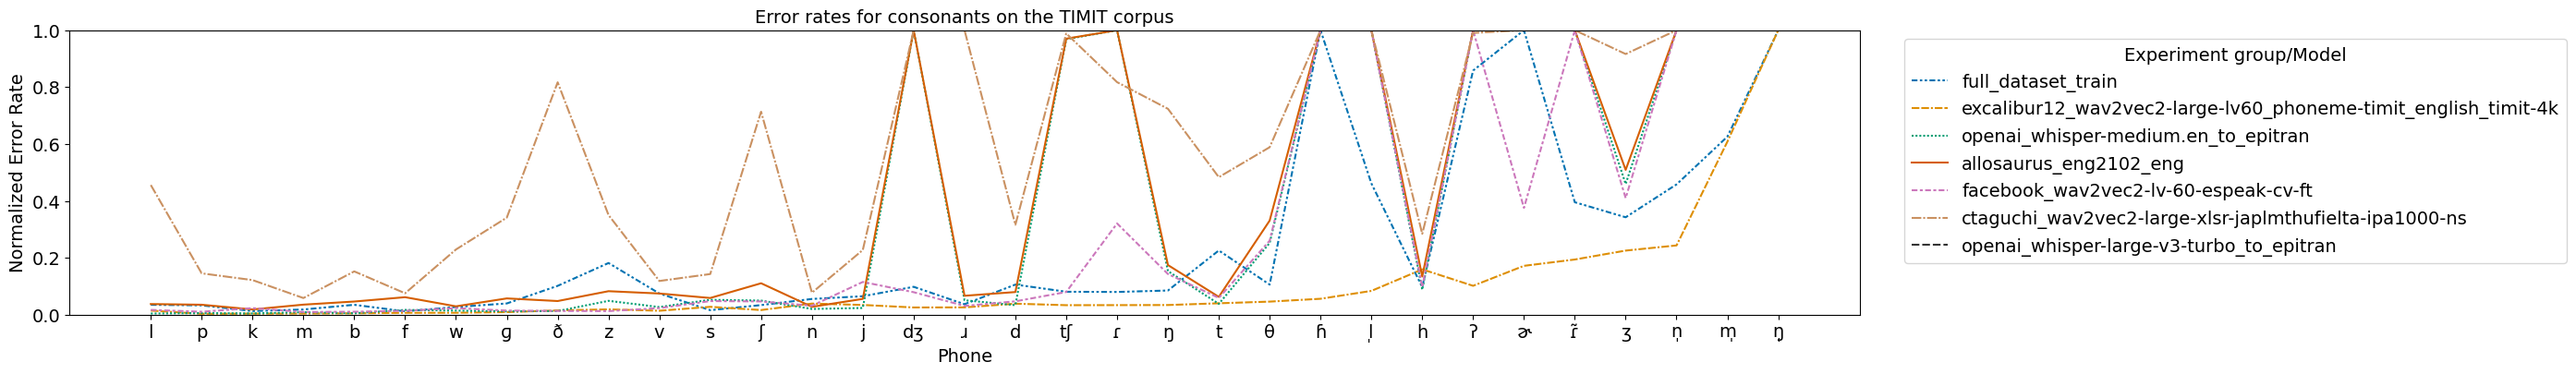

In [7]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(TIMIT_CONSONANTS)]
plot_error_rates_by_phone_and_model(consonant_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for consonants on the TIMIT corpus")

<Axes: title={'center': 'Error rates for vowels on the TIMIT corpus'}, xlabel='Phone', ylabel='Normalized Error Rate'>

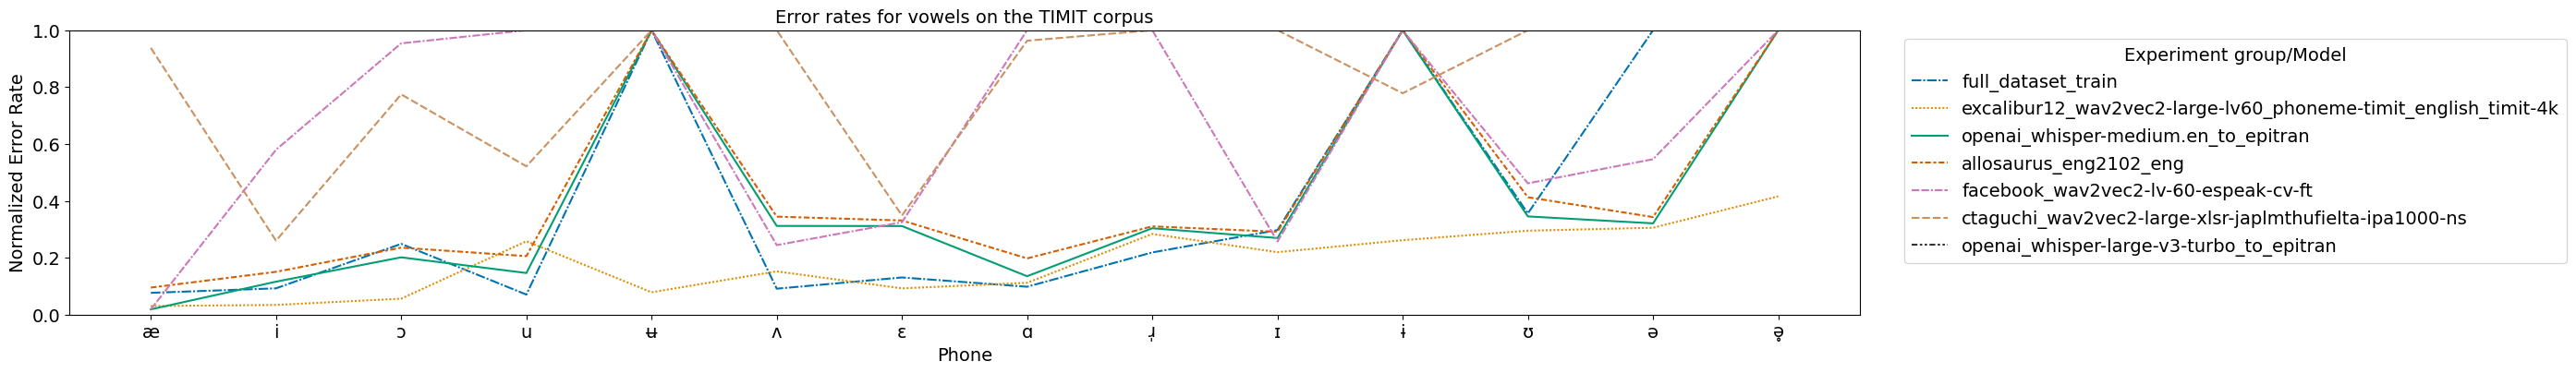

In [8]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(TIMIT_VOWELS)]
plot_error_rates_by_phone_and_model(vowel_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for vowels on the TIMIT corpus")

In [9]:
our_models = all_error_rates_df[all_error_rates_df["model_group"] == "full_dataset_train"]

<Axes: title={'center': 'AutoIPA model error rates for consonants on the TIMIT corpus\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

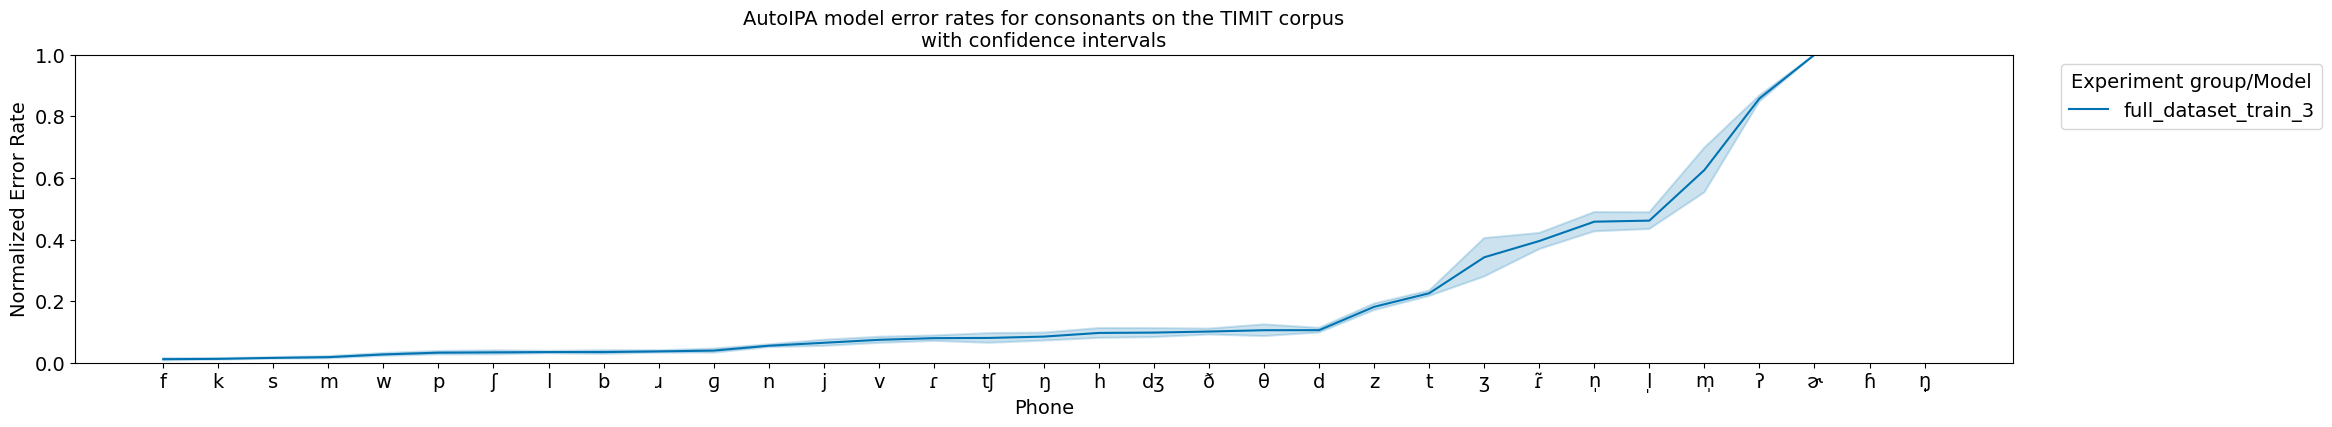

In [10]:
our_models_consonants = our_models[our_models["phone"].isin(TIMIT_CONSONANTS)]
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", palette=PALETTE, title="AutoIPA model error rates for consonants on the TIMIT corpus\nwith confidence intervals", use_confidence_intervals=True)

<Axes: title={'center': 'AutoIPA model error rates for consonants on the TIMIT corpus'}, xlabel='Phone', ylabel='Normalized Error Rate'>

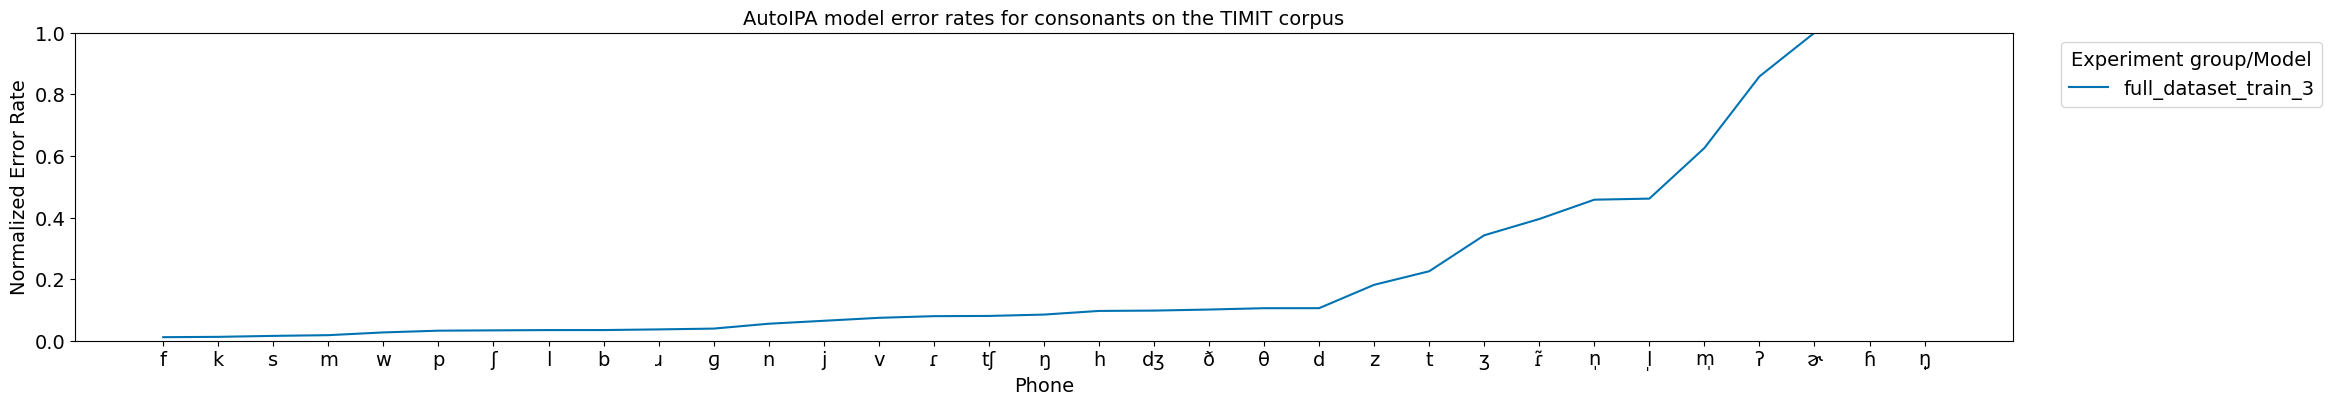

In [11]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_name", palette=PALETTE, title="AutoIPA model error rates for consonants on the TIMIT corpus")

<Axes: title={'center': 'AutoIPA model error rates for vowels on the TIMIT corpus\nwith confidence intervals'}, xlabel='Phone', ylabel='Normalized Error Rate'>

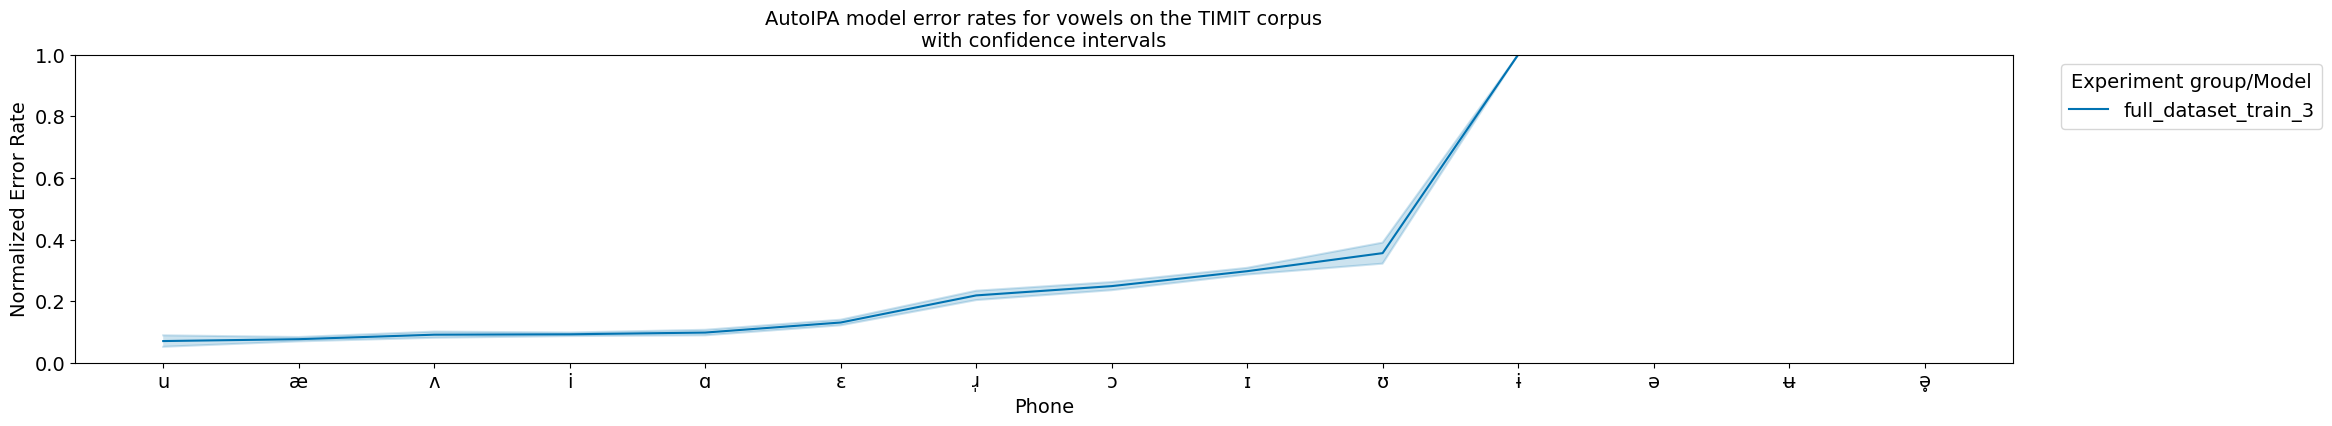

In [12]:
our_models_vowels = our_models[our_models["phone"].isin(TIMIT_VOWELS)]
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", palette=PALETTE, title="AutoIPA model error rates for vowels on the TIMIT corpus\nwith confidence intervals", use_confidence_intervals=True)

<Axes: title={'center': 'AutoIPA model error rates for vowels on the TIMIT corpus'}, xlabel='Phone', ylabel='Normalized Error Rate'>

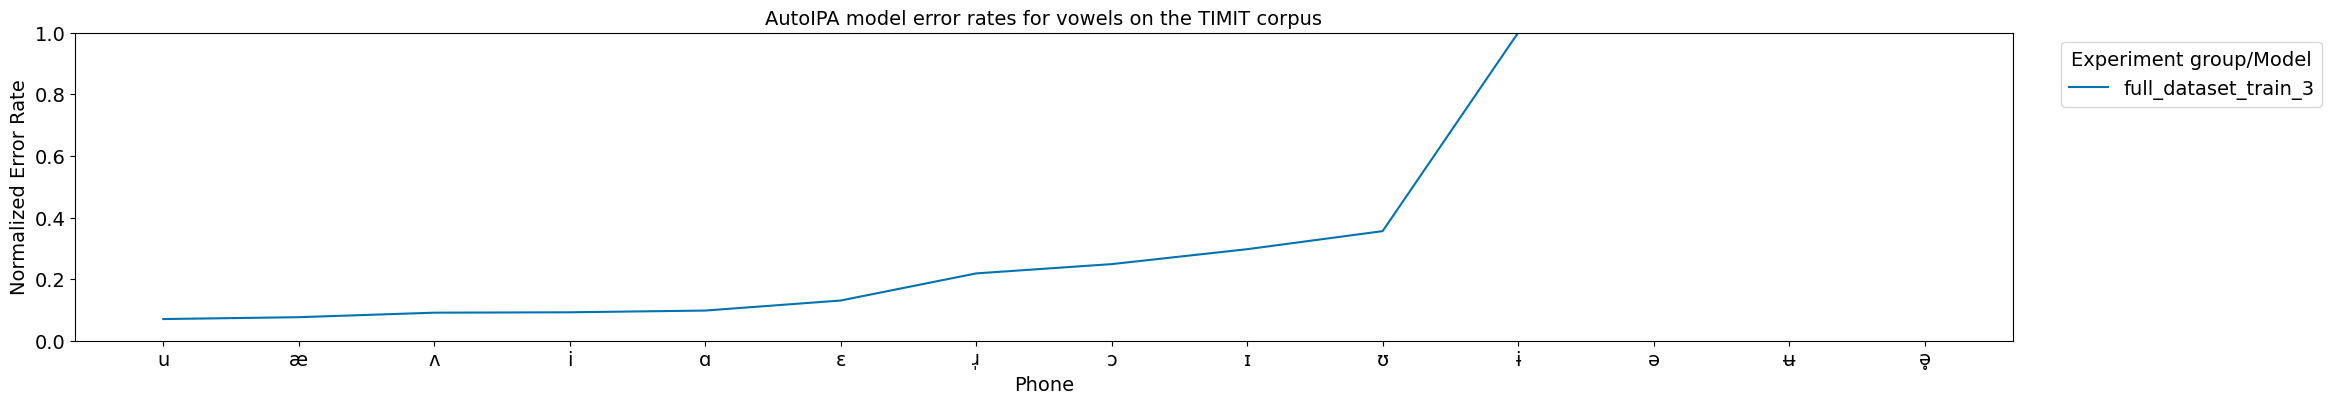

In [13]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_name", palette=PALETTE, title="AutoIPA model error rates for vowels on the TIMIT corpus")

<Axes: title={'center': 'Error rates for consonants on the Buckeye test\naveraged across AutoIPA experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

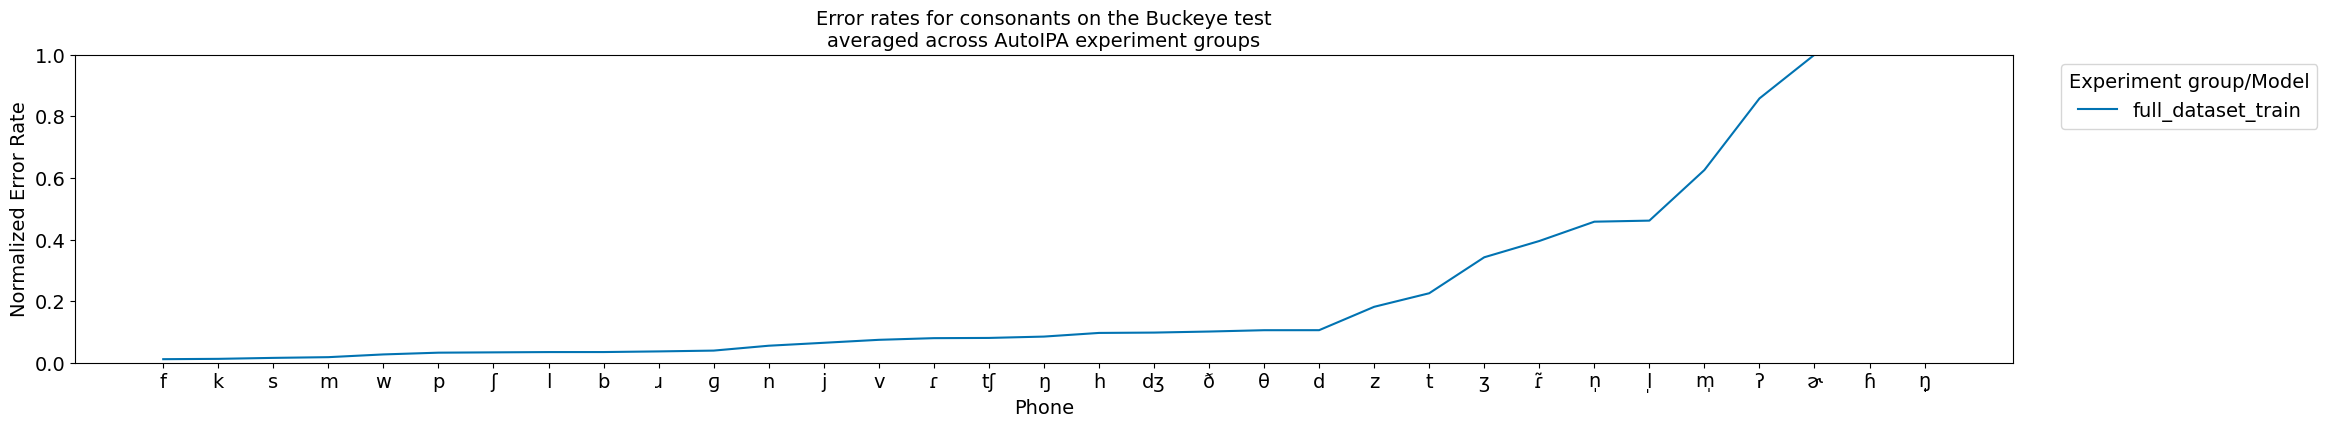

In [14]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_group", palette=PALETTE, title="Error rates for consonants on the Buckeye test\naveraged across AutoIPA experiment groups",)

<Axes: title={'center': 'Error rates for vowels on the Buckeye test\naveraged across AutoIPA experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

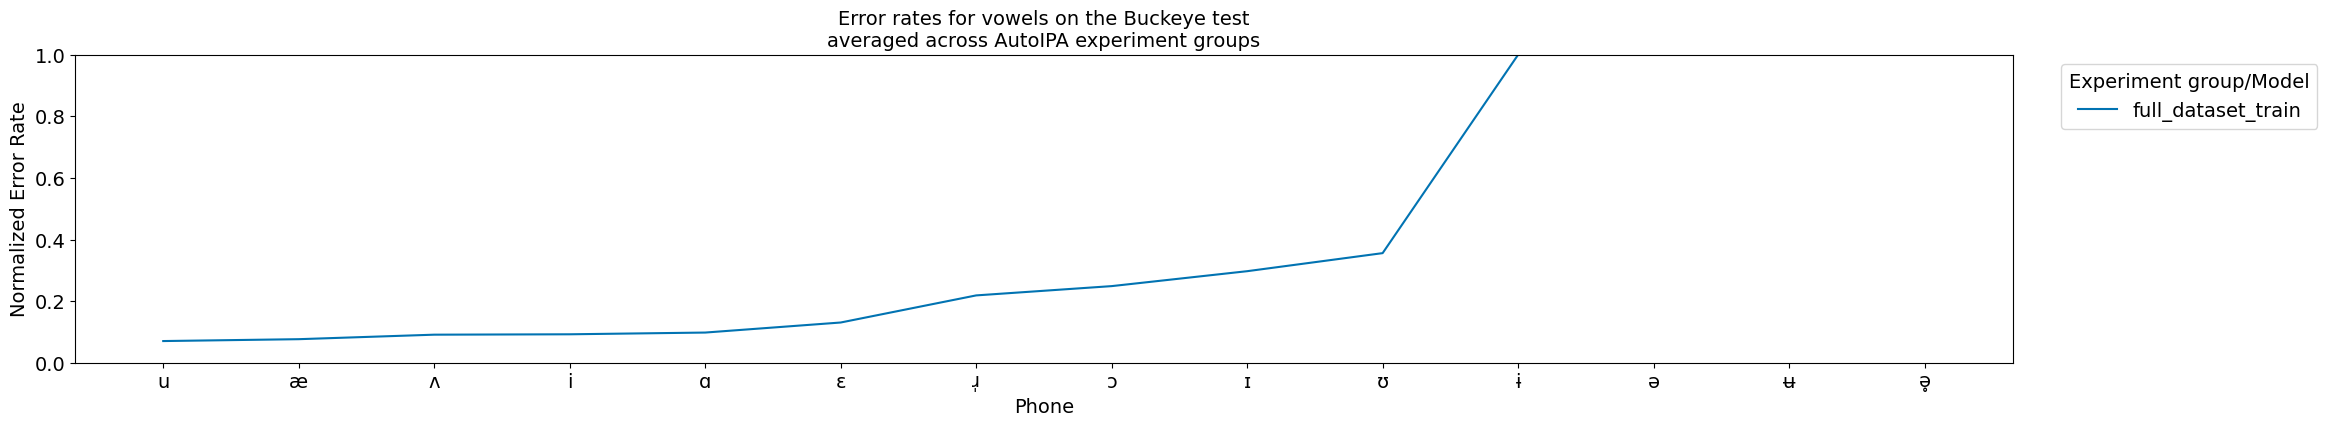

In [15]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_group", palette=PALETTE, title="Error rates for vowels on the Buckeye test\naveraged across AutoIPA experiment groups",)

# Confusion matrices
Get the confusion matrix for each model's errors. Display confusion matrix separated by consonants and vowels separately for a few select models. 

In [16]:
# Gets the confusion matrix for each model
conf_matrices = {}
for mn in model_names:
    print("Model name:", mn)
    conf_matrices[mn] = MODEL_EVALUATOR.get_token_confusion_matrix(mn)


Model name: full_dataset_train_3
Model name: openai_whisper-large-v3-turbo_to_epitran
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k


<Figure size 640x480 with 0 Axes>

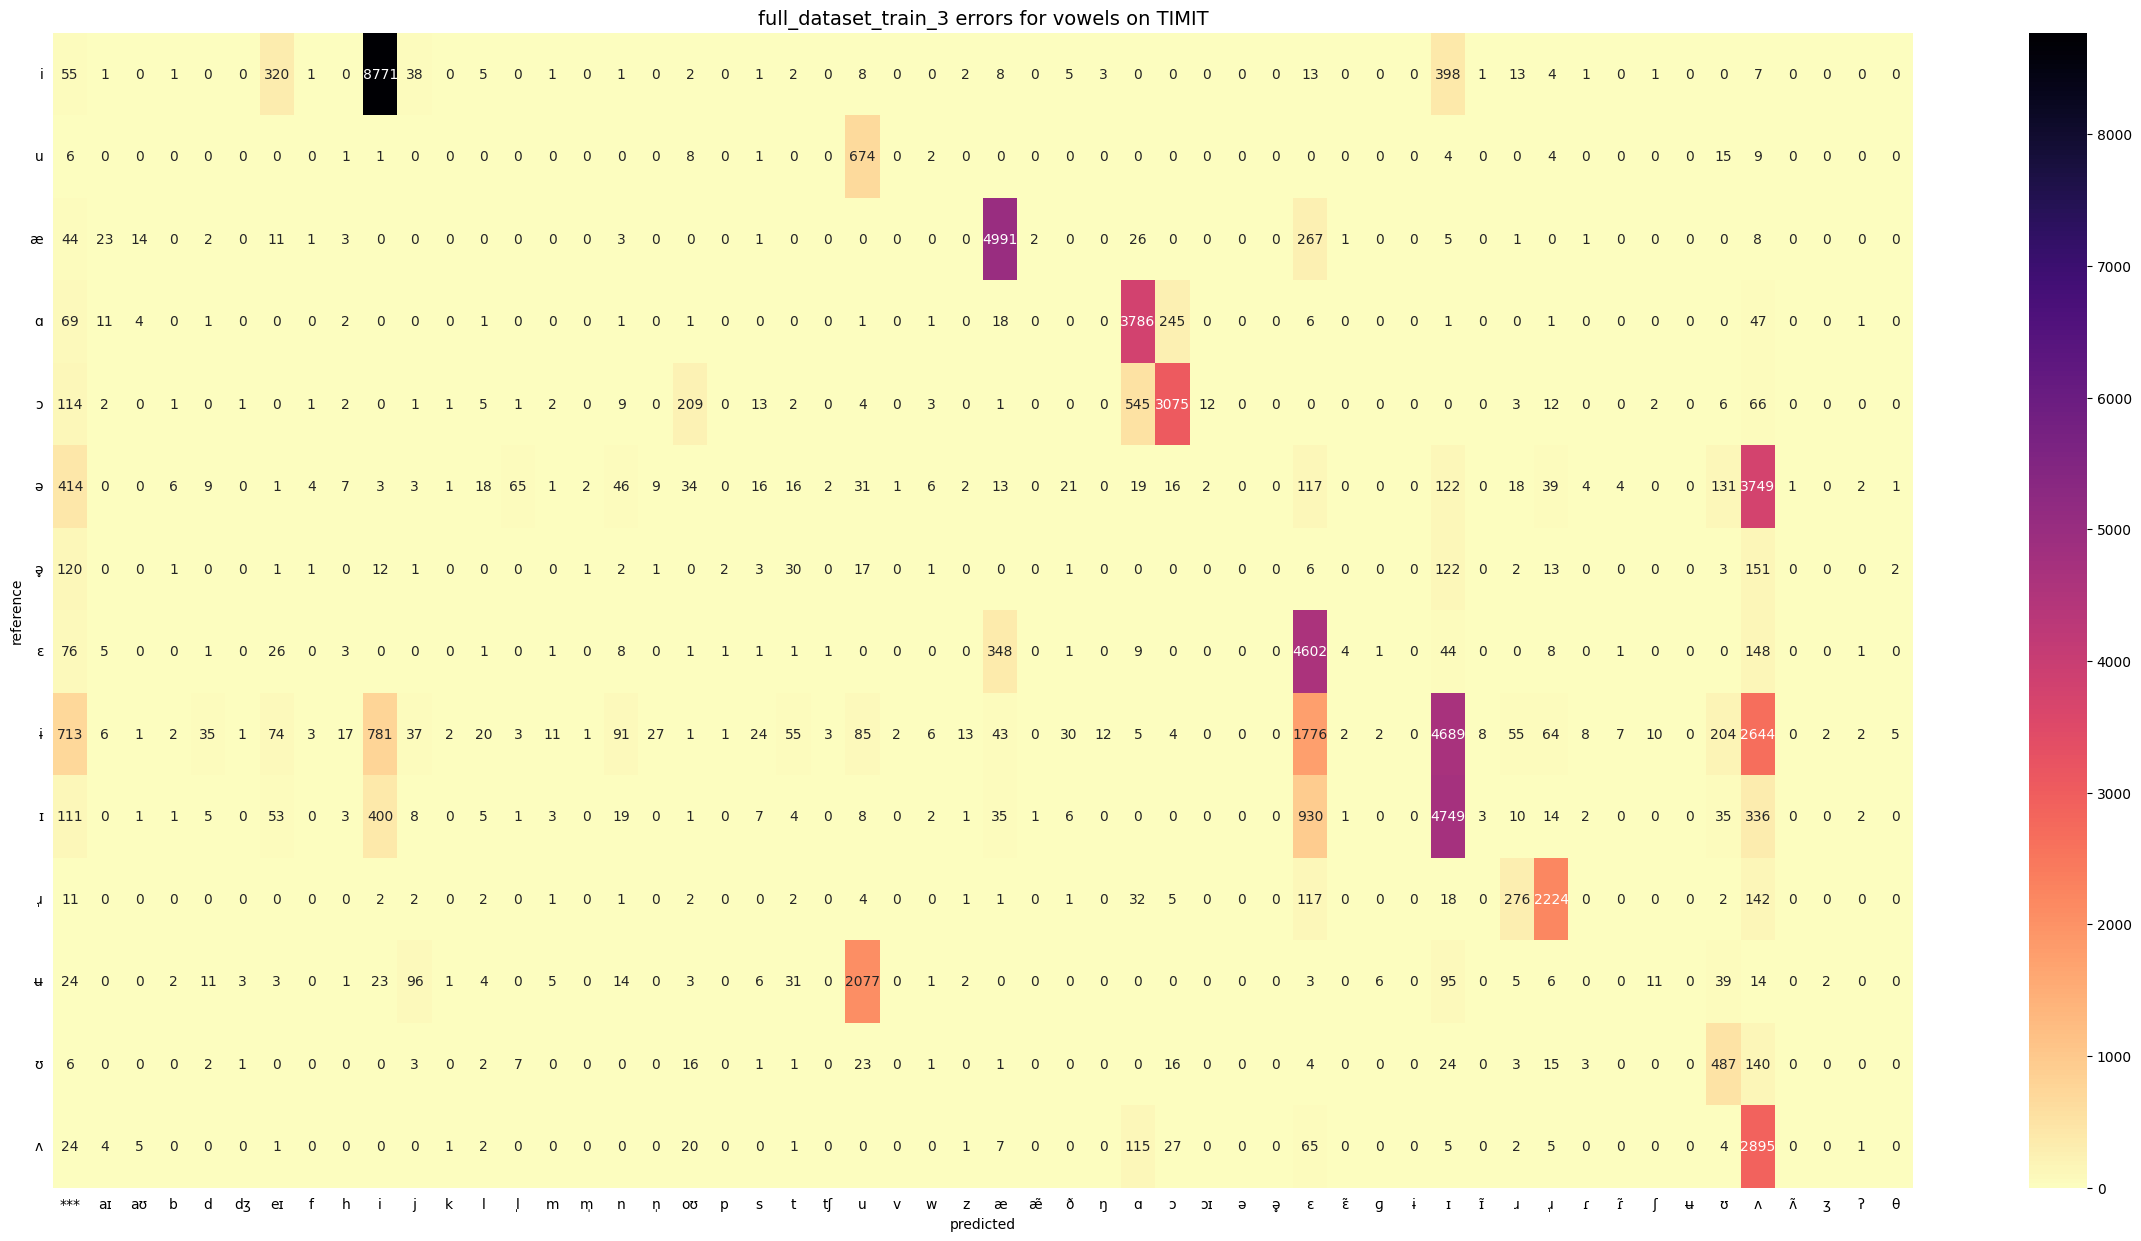

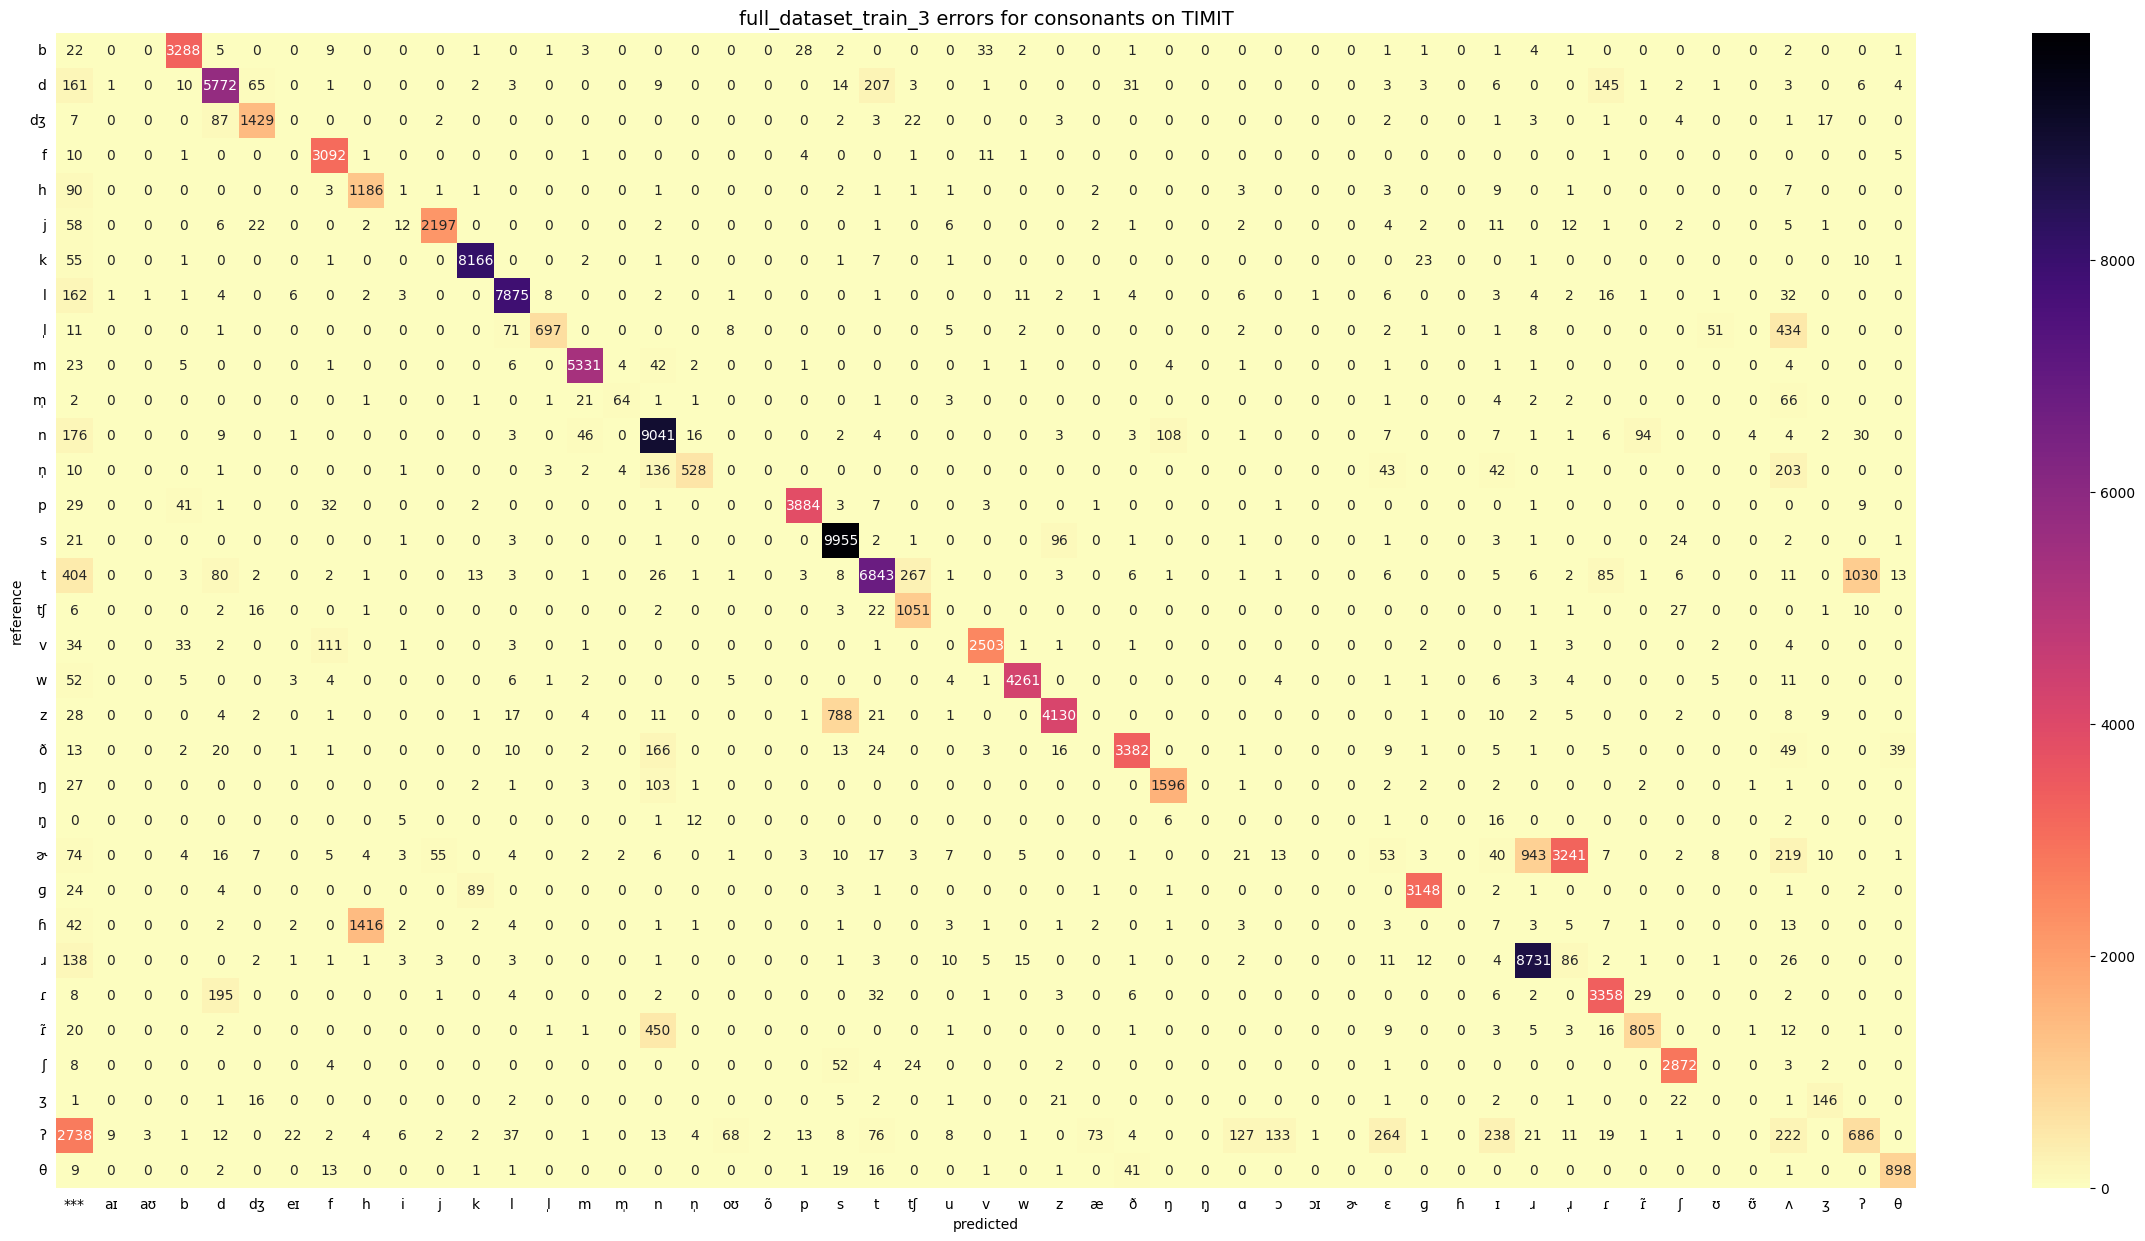

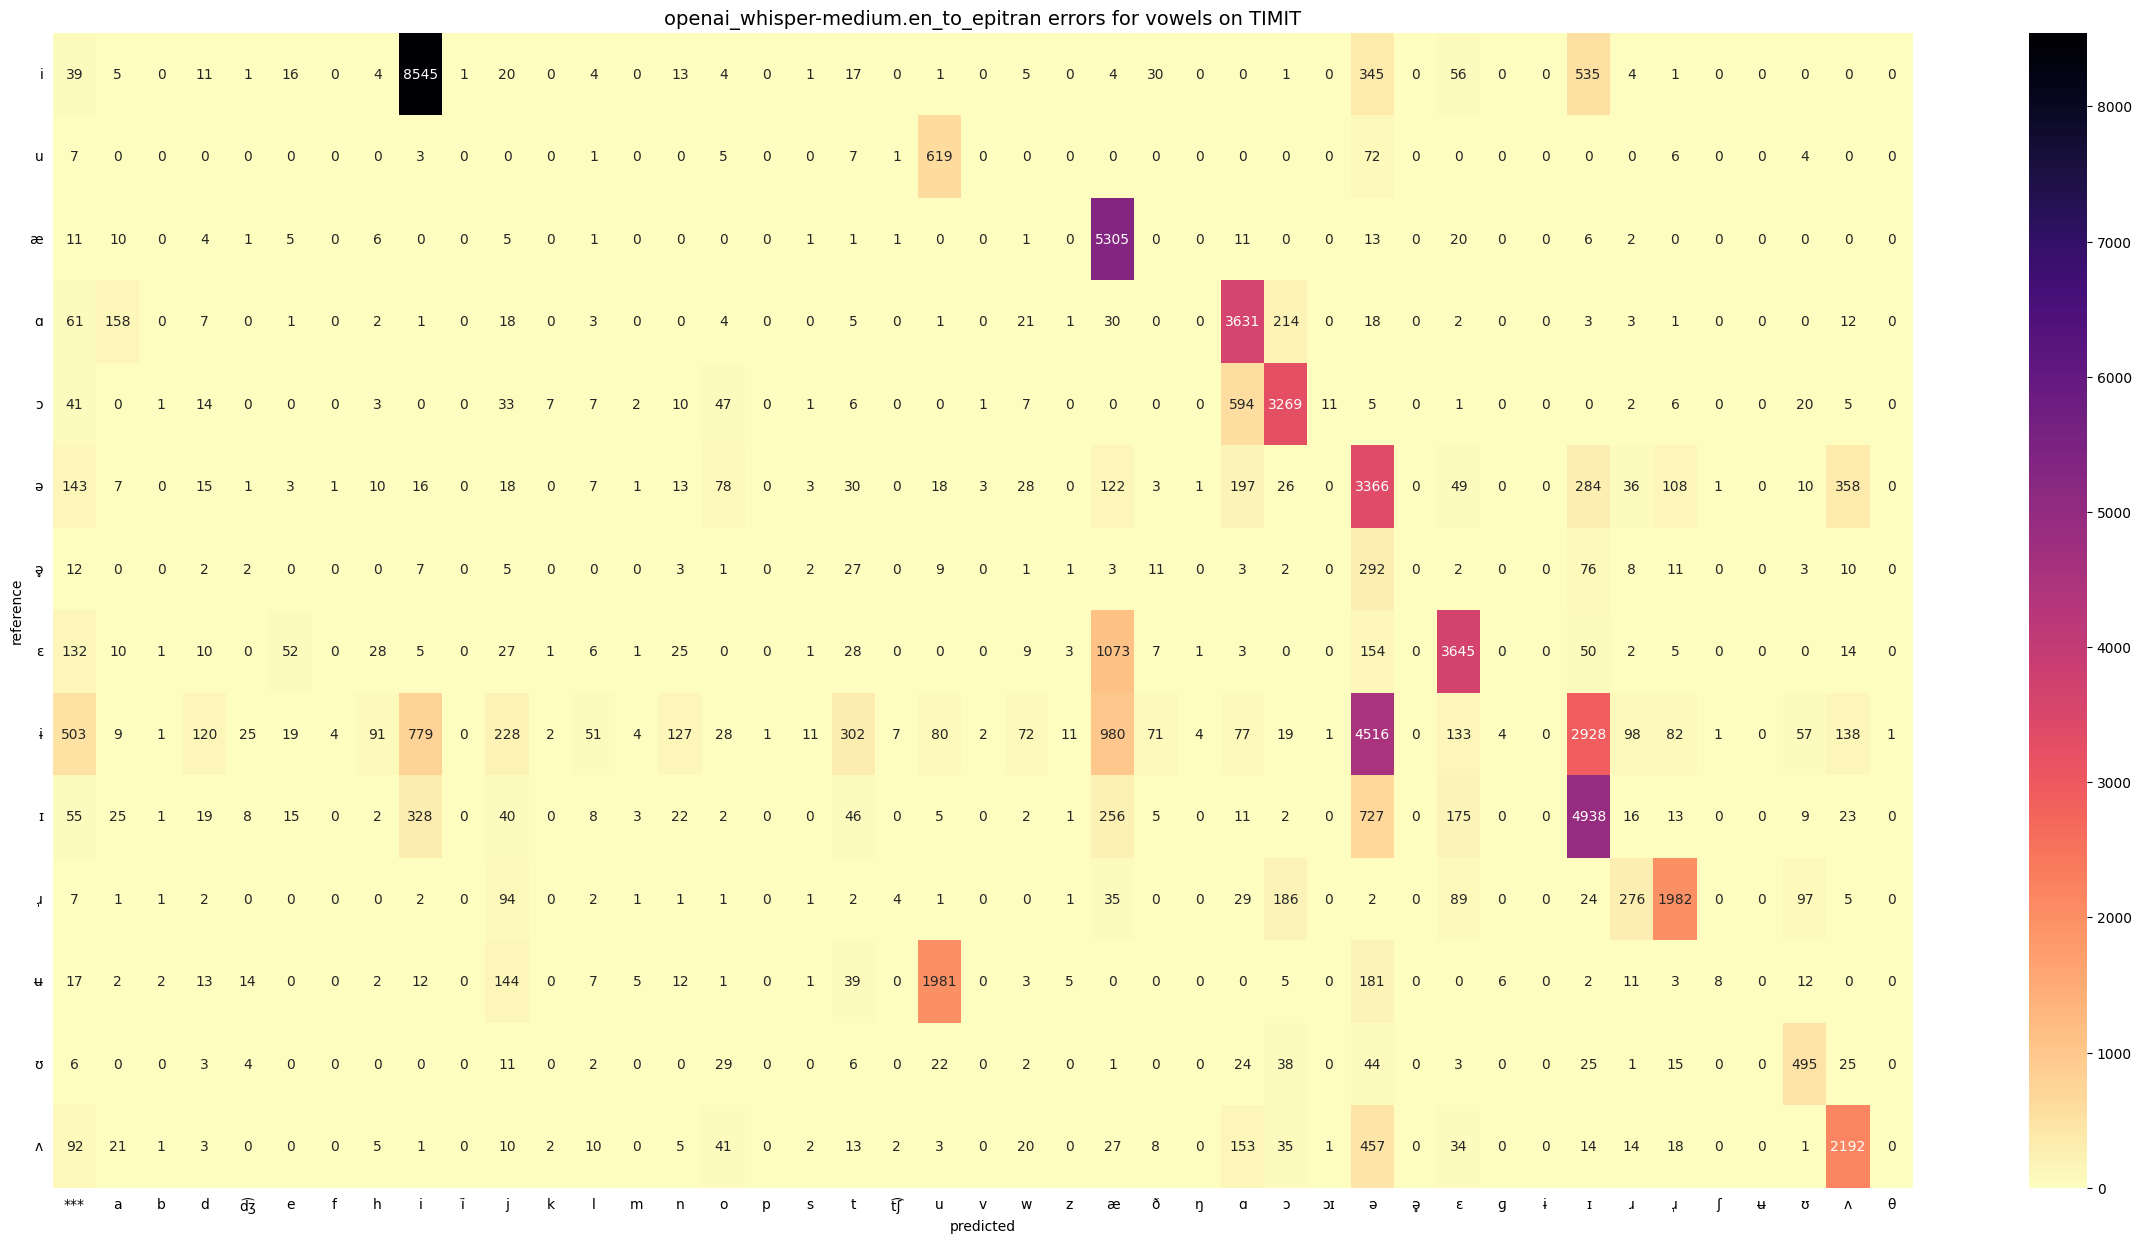

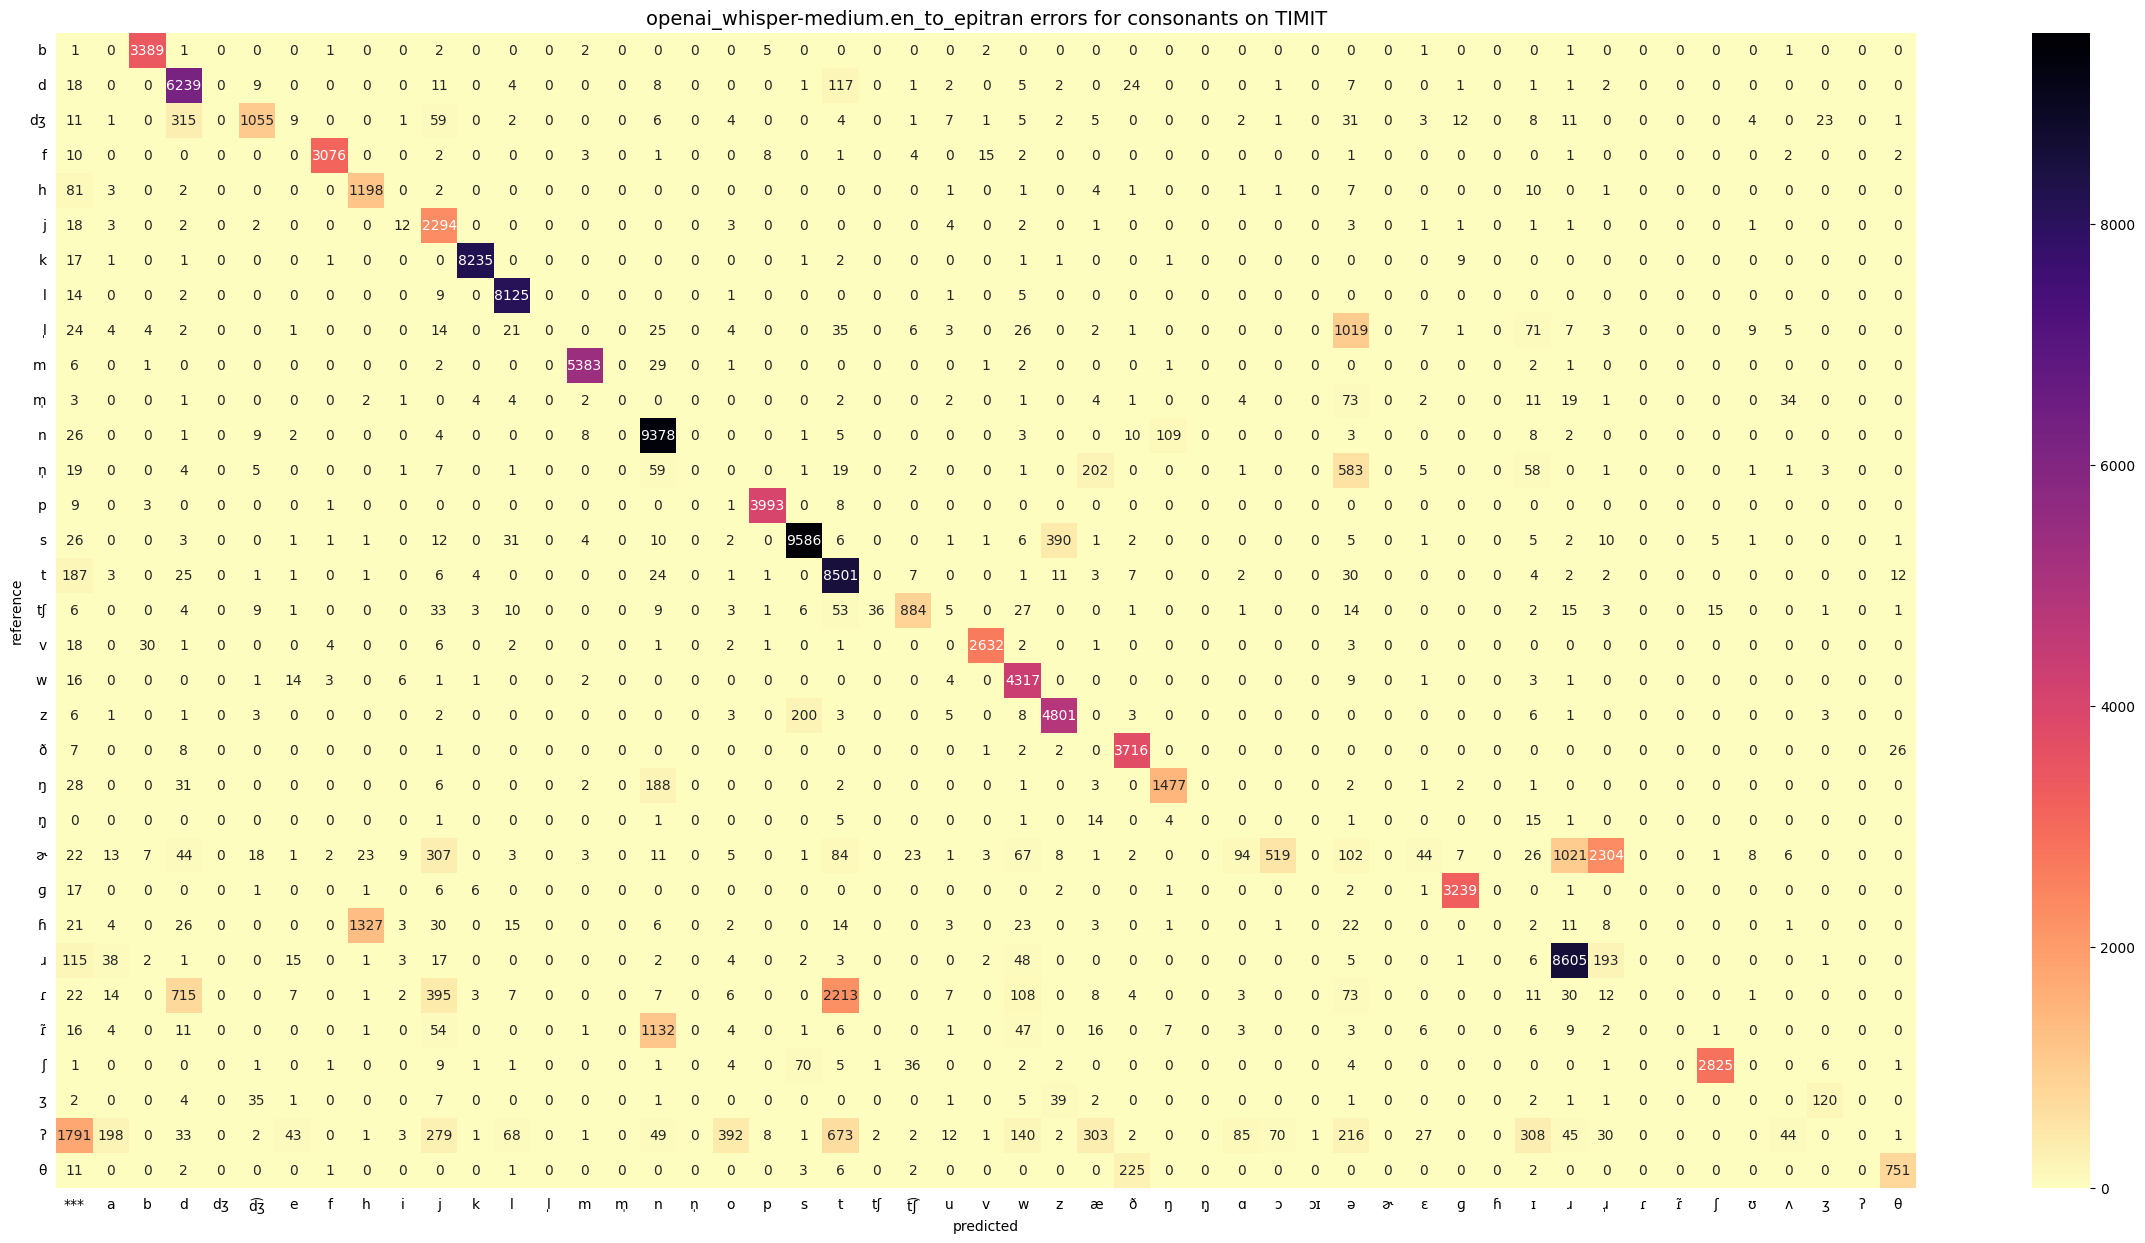

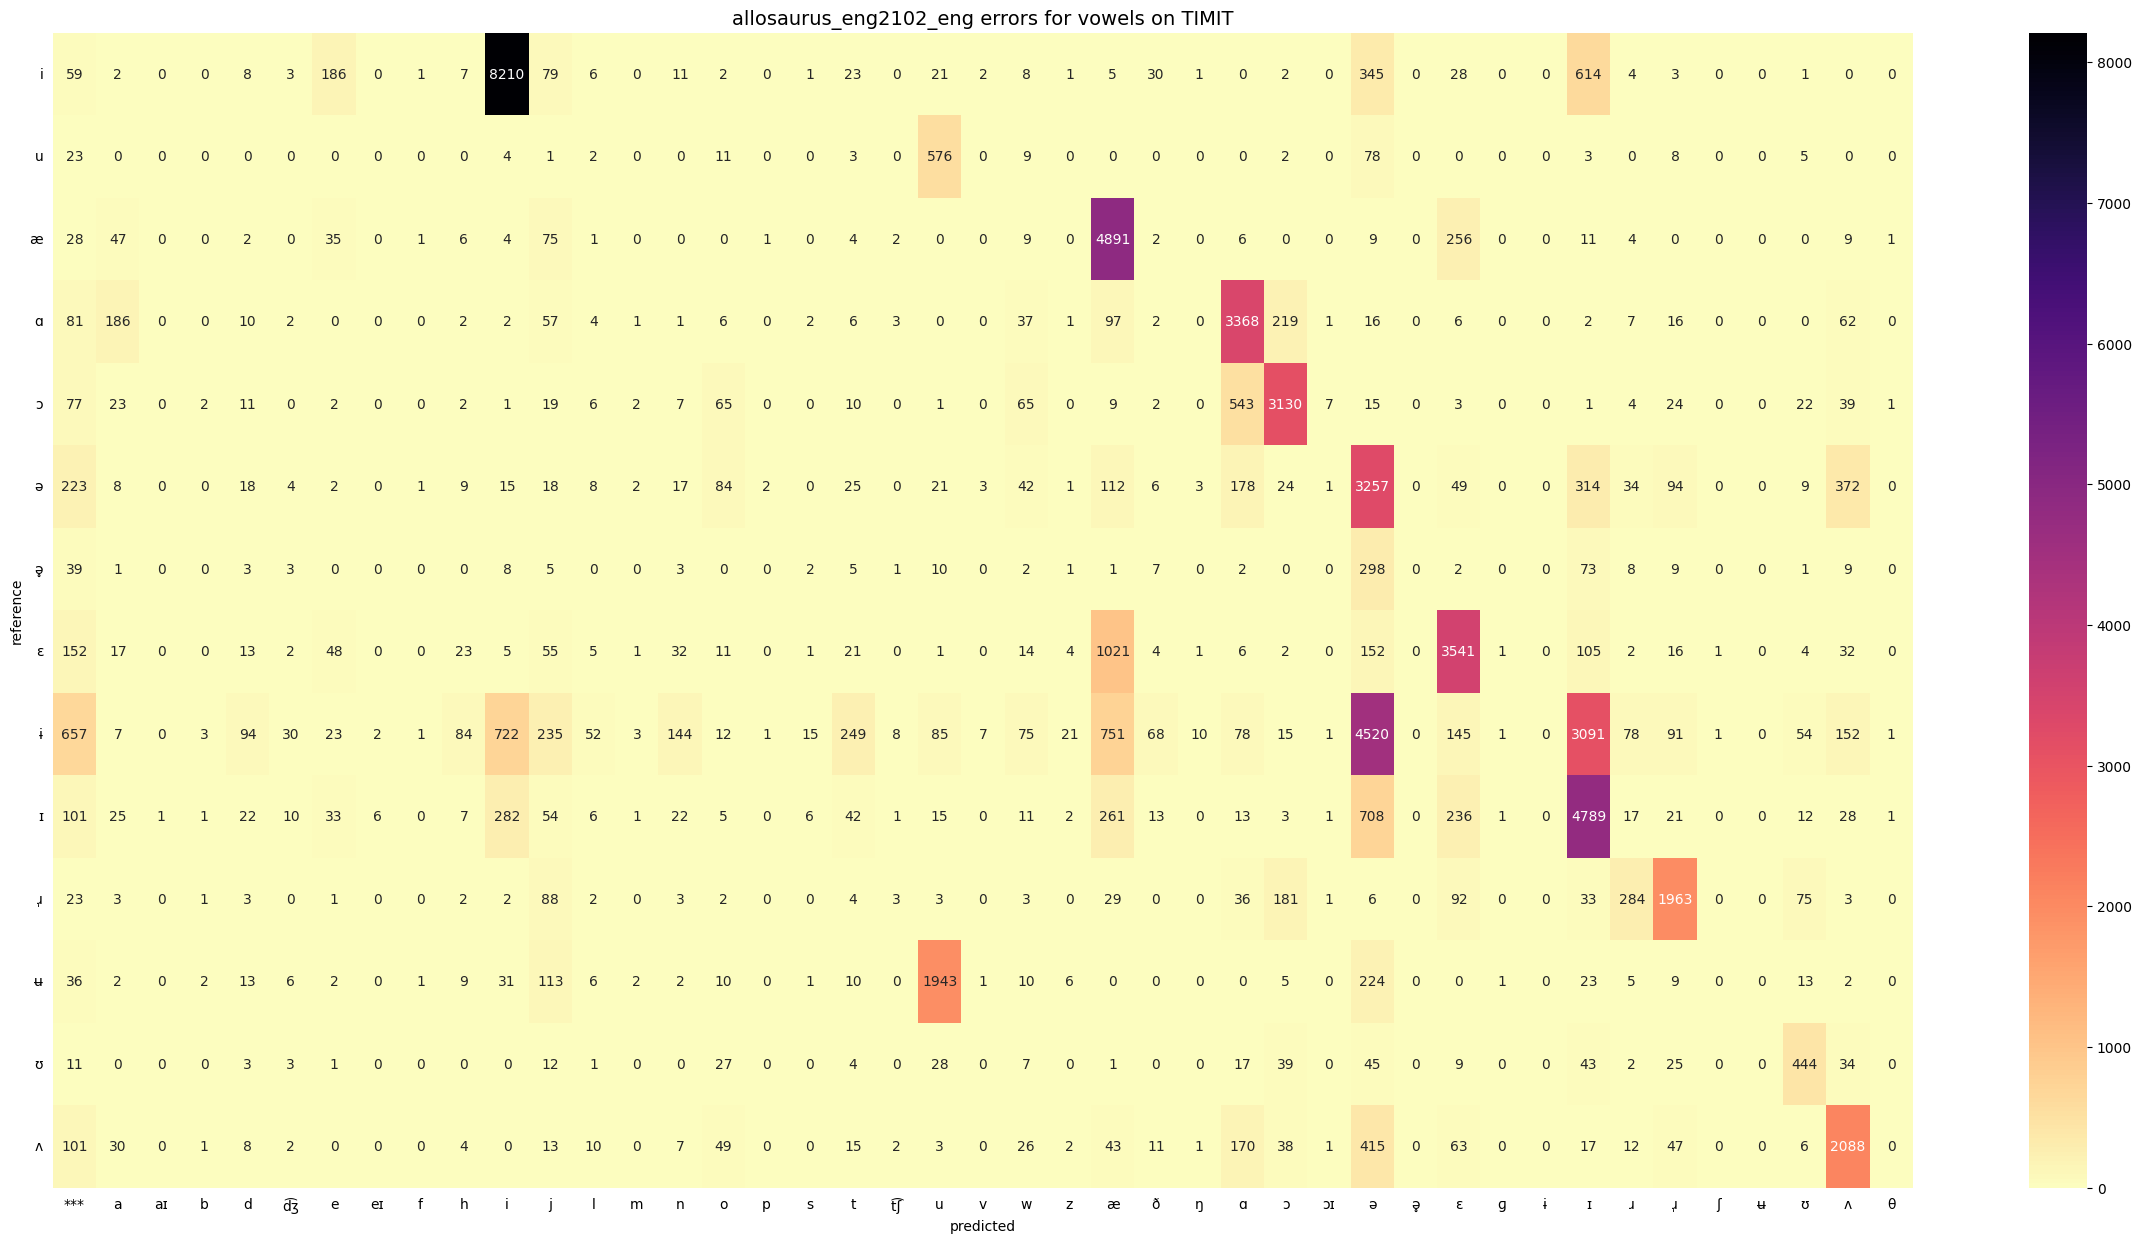

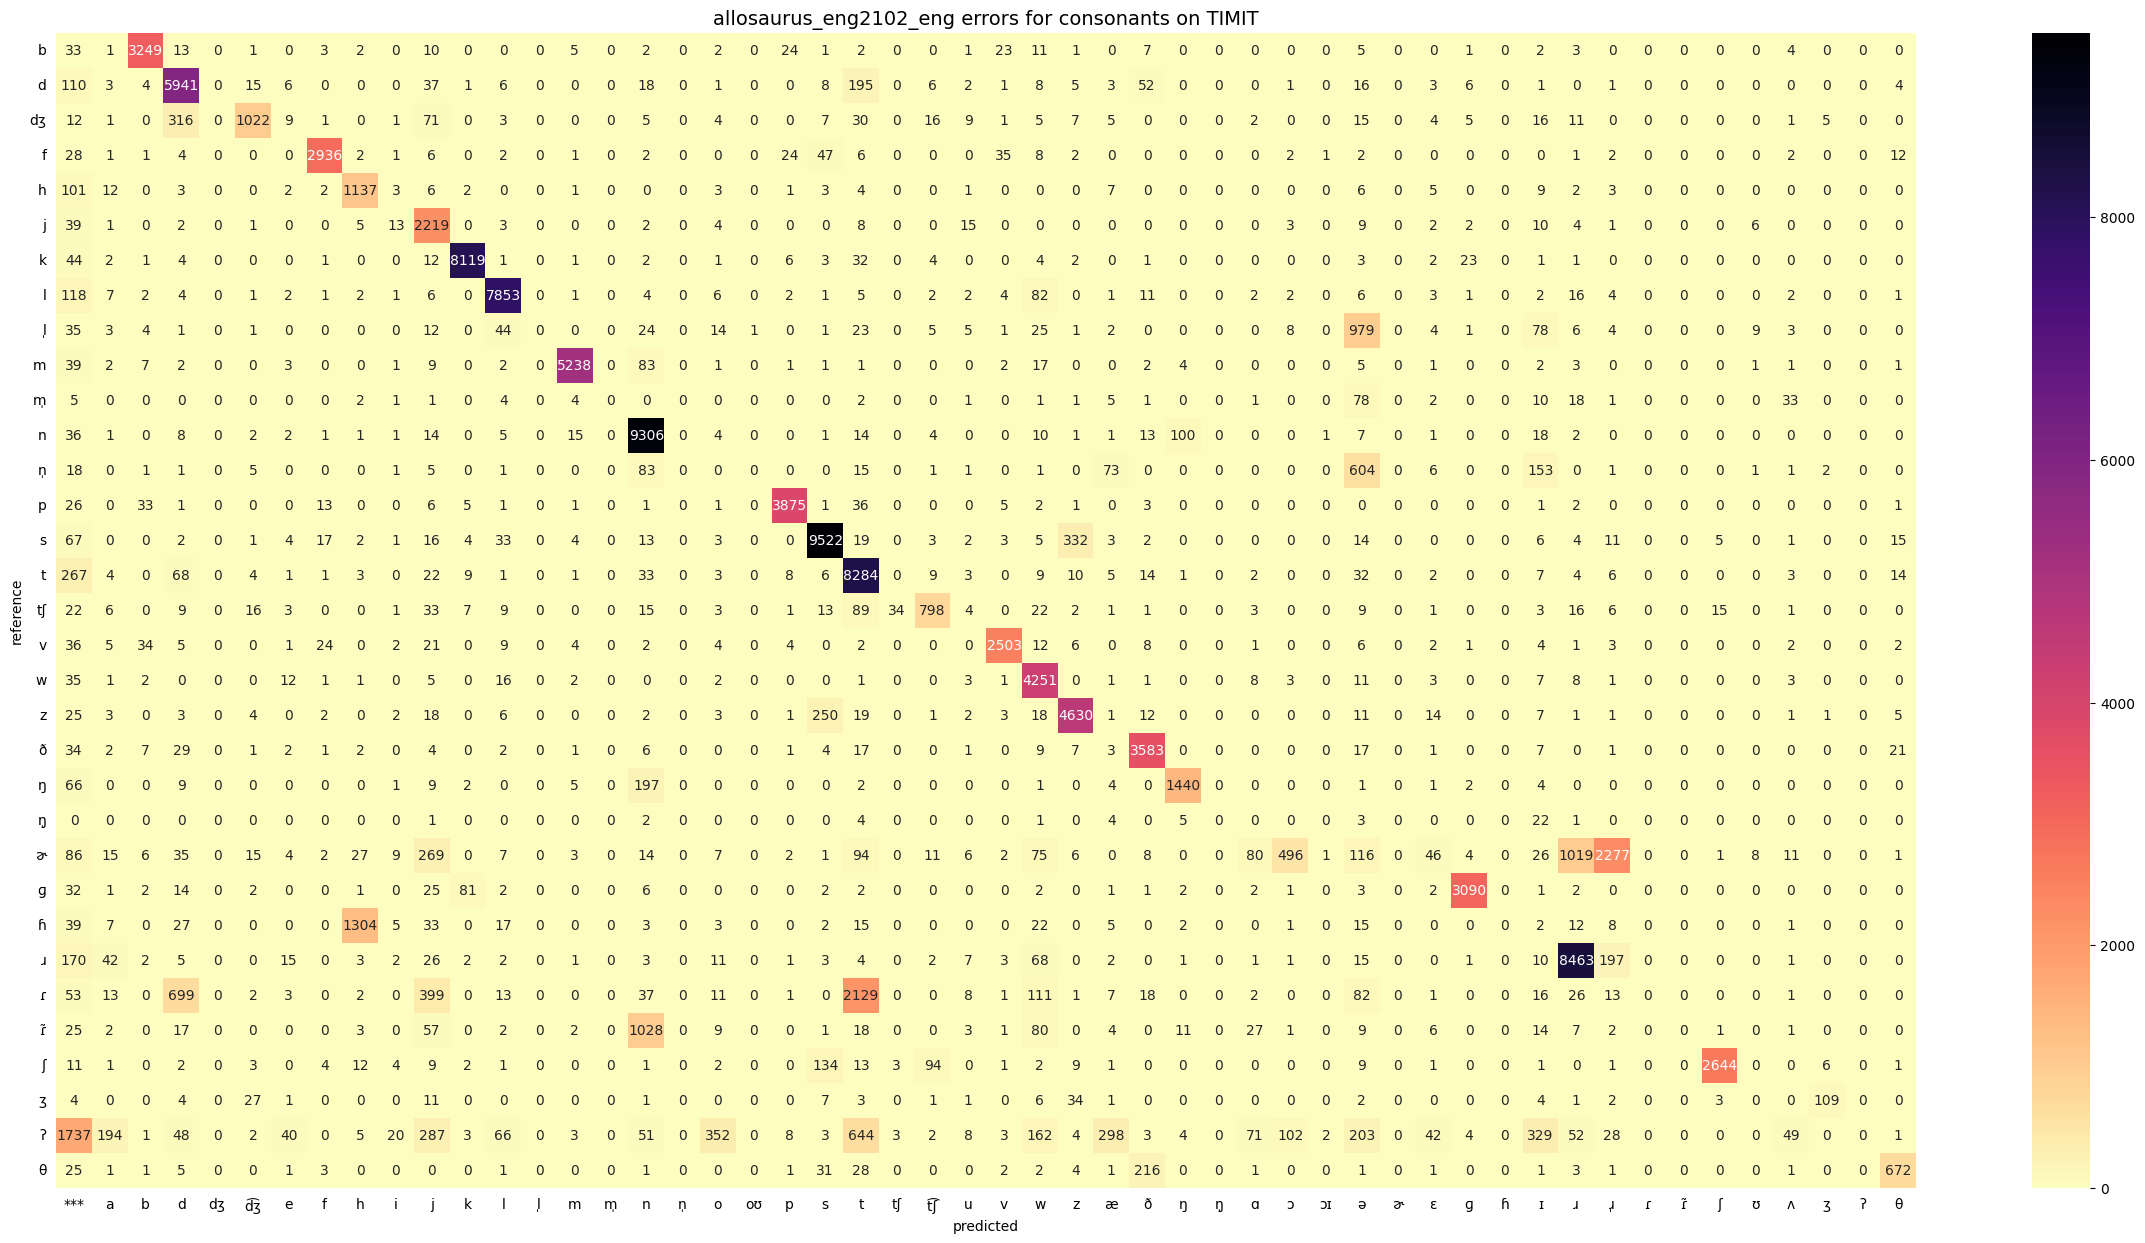

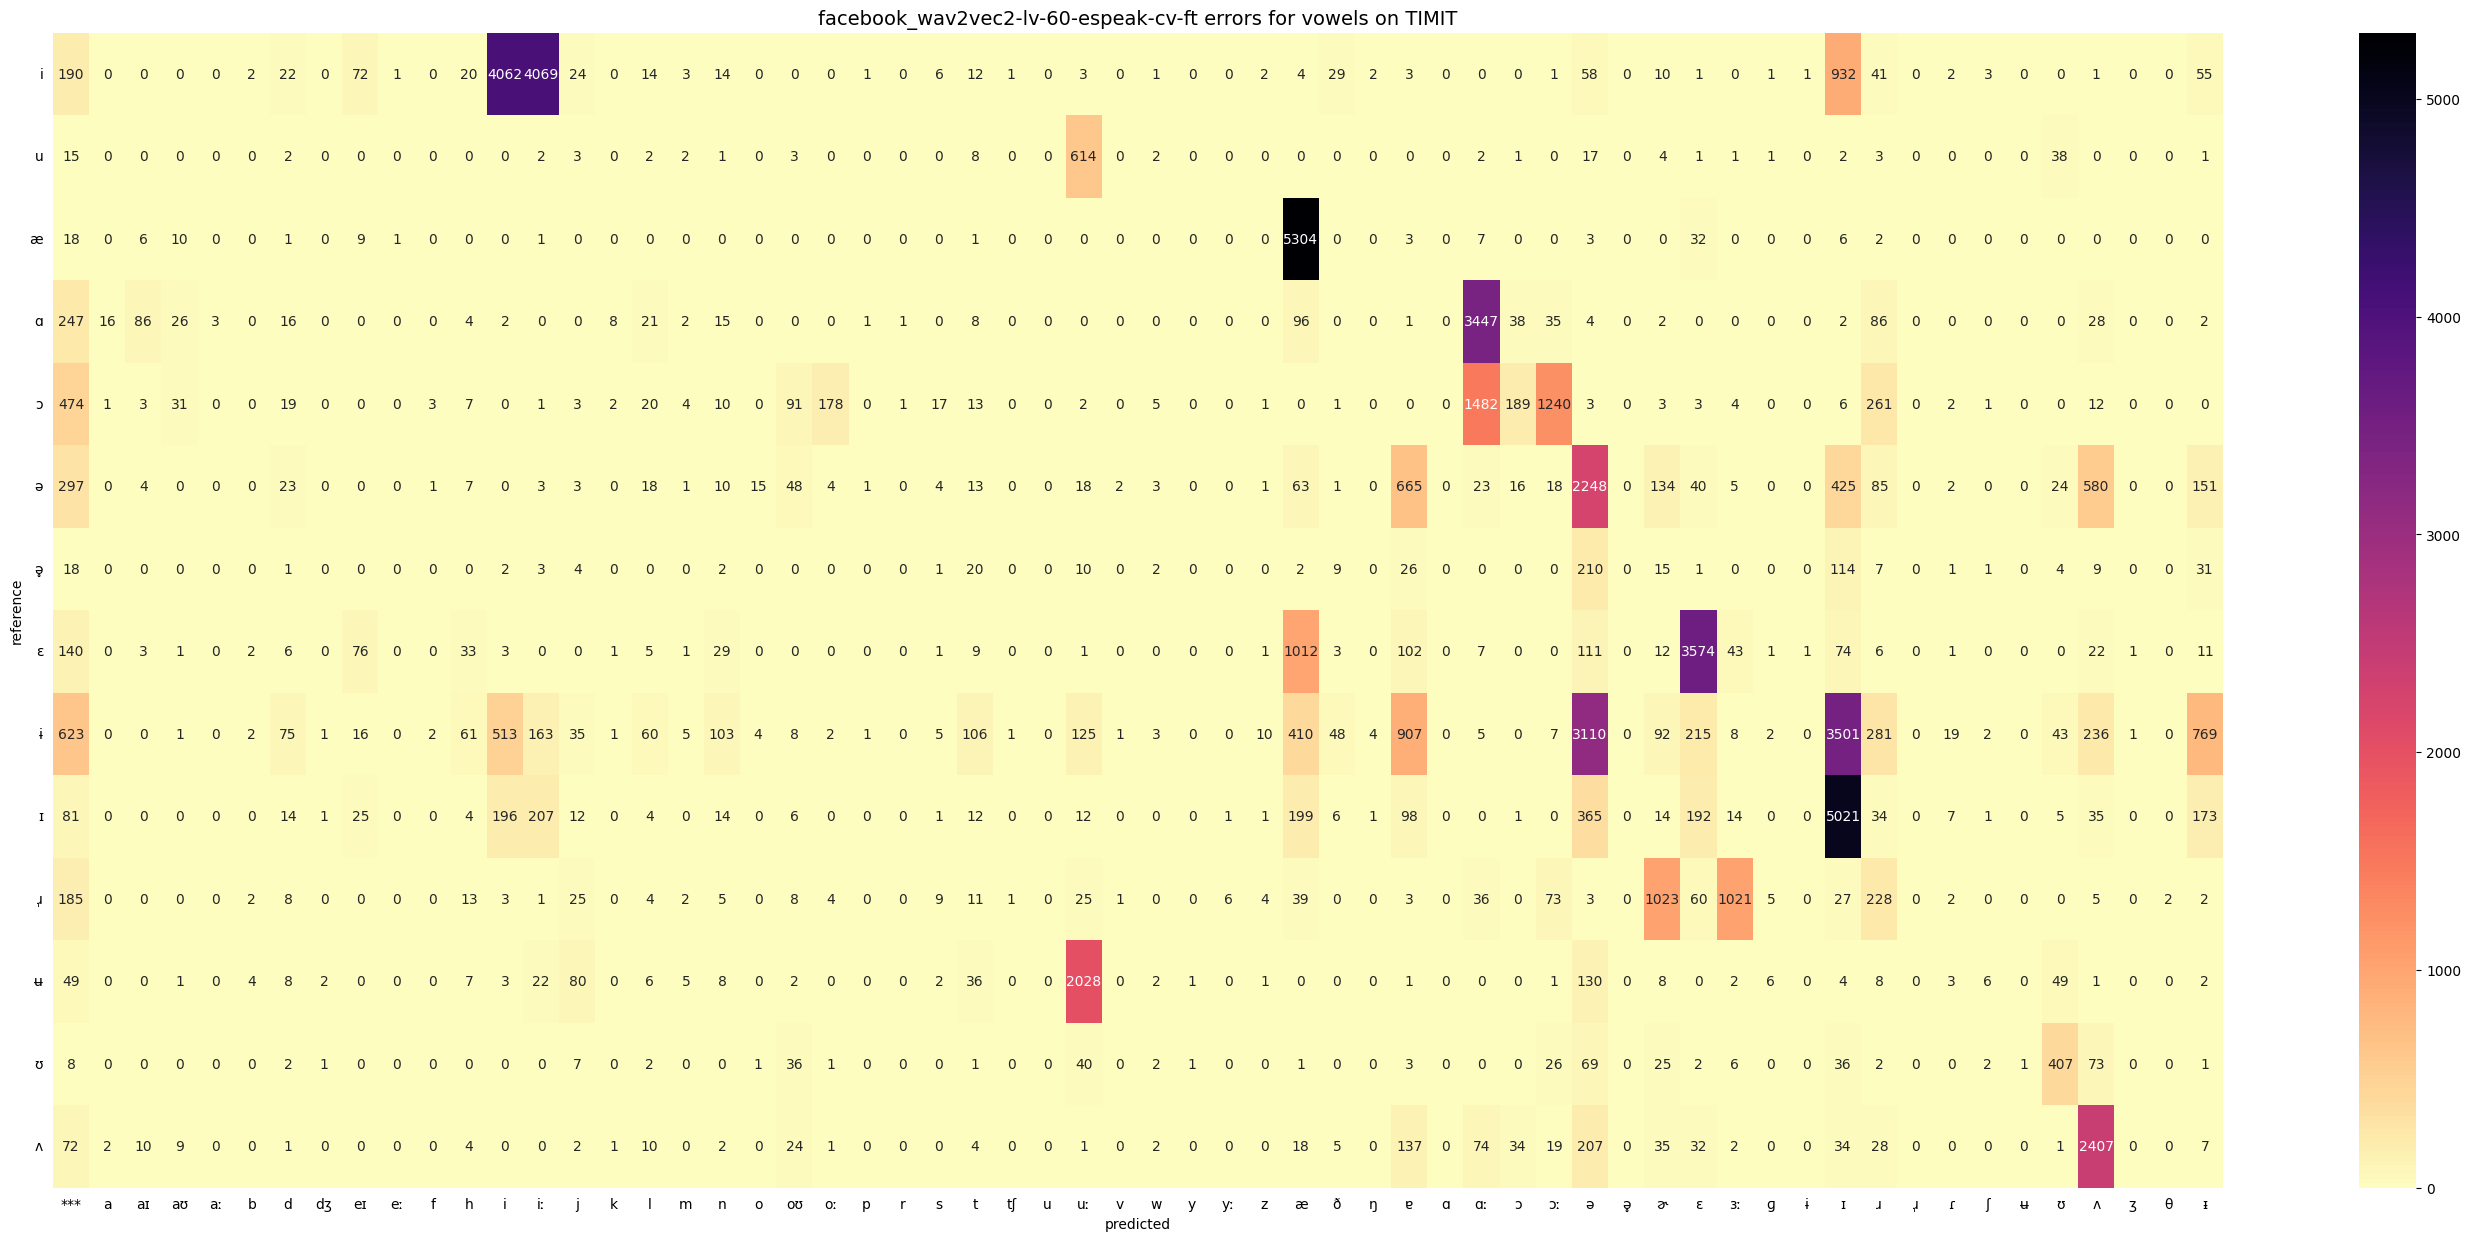

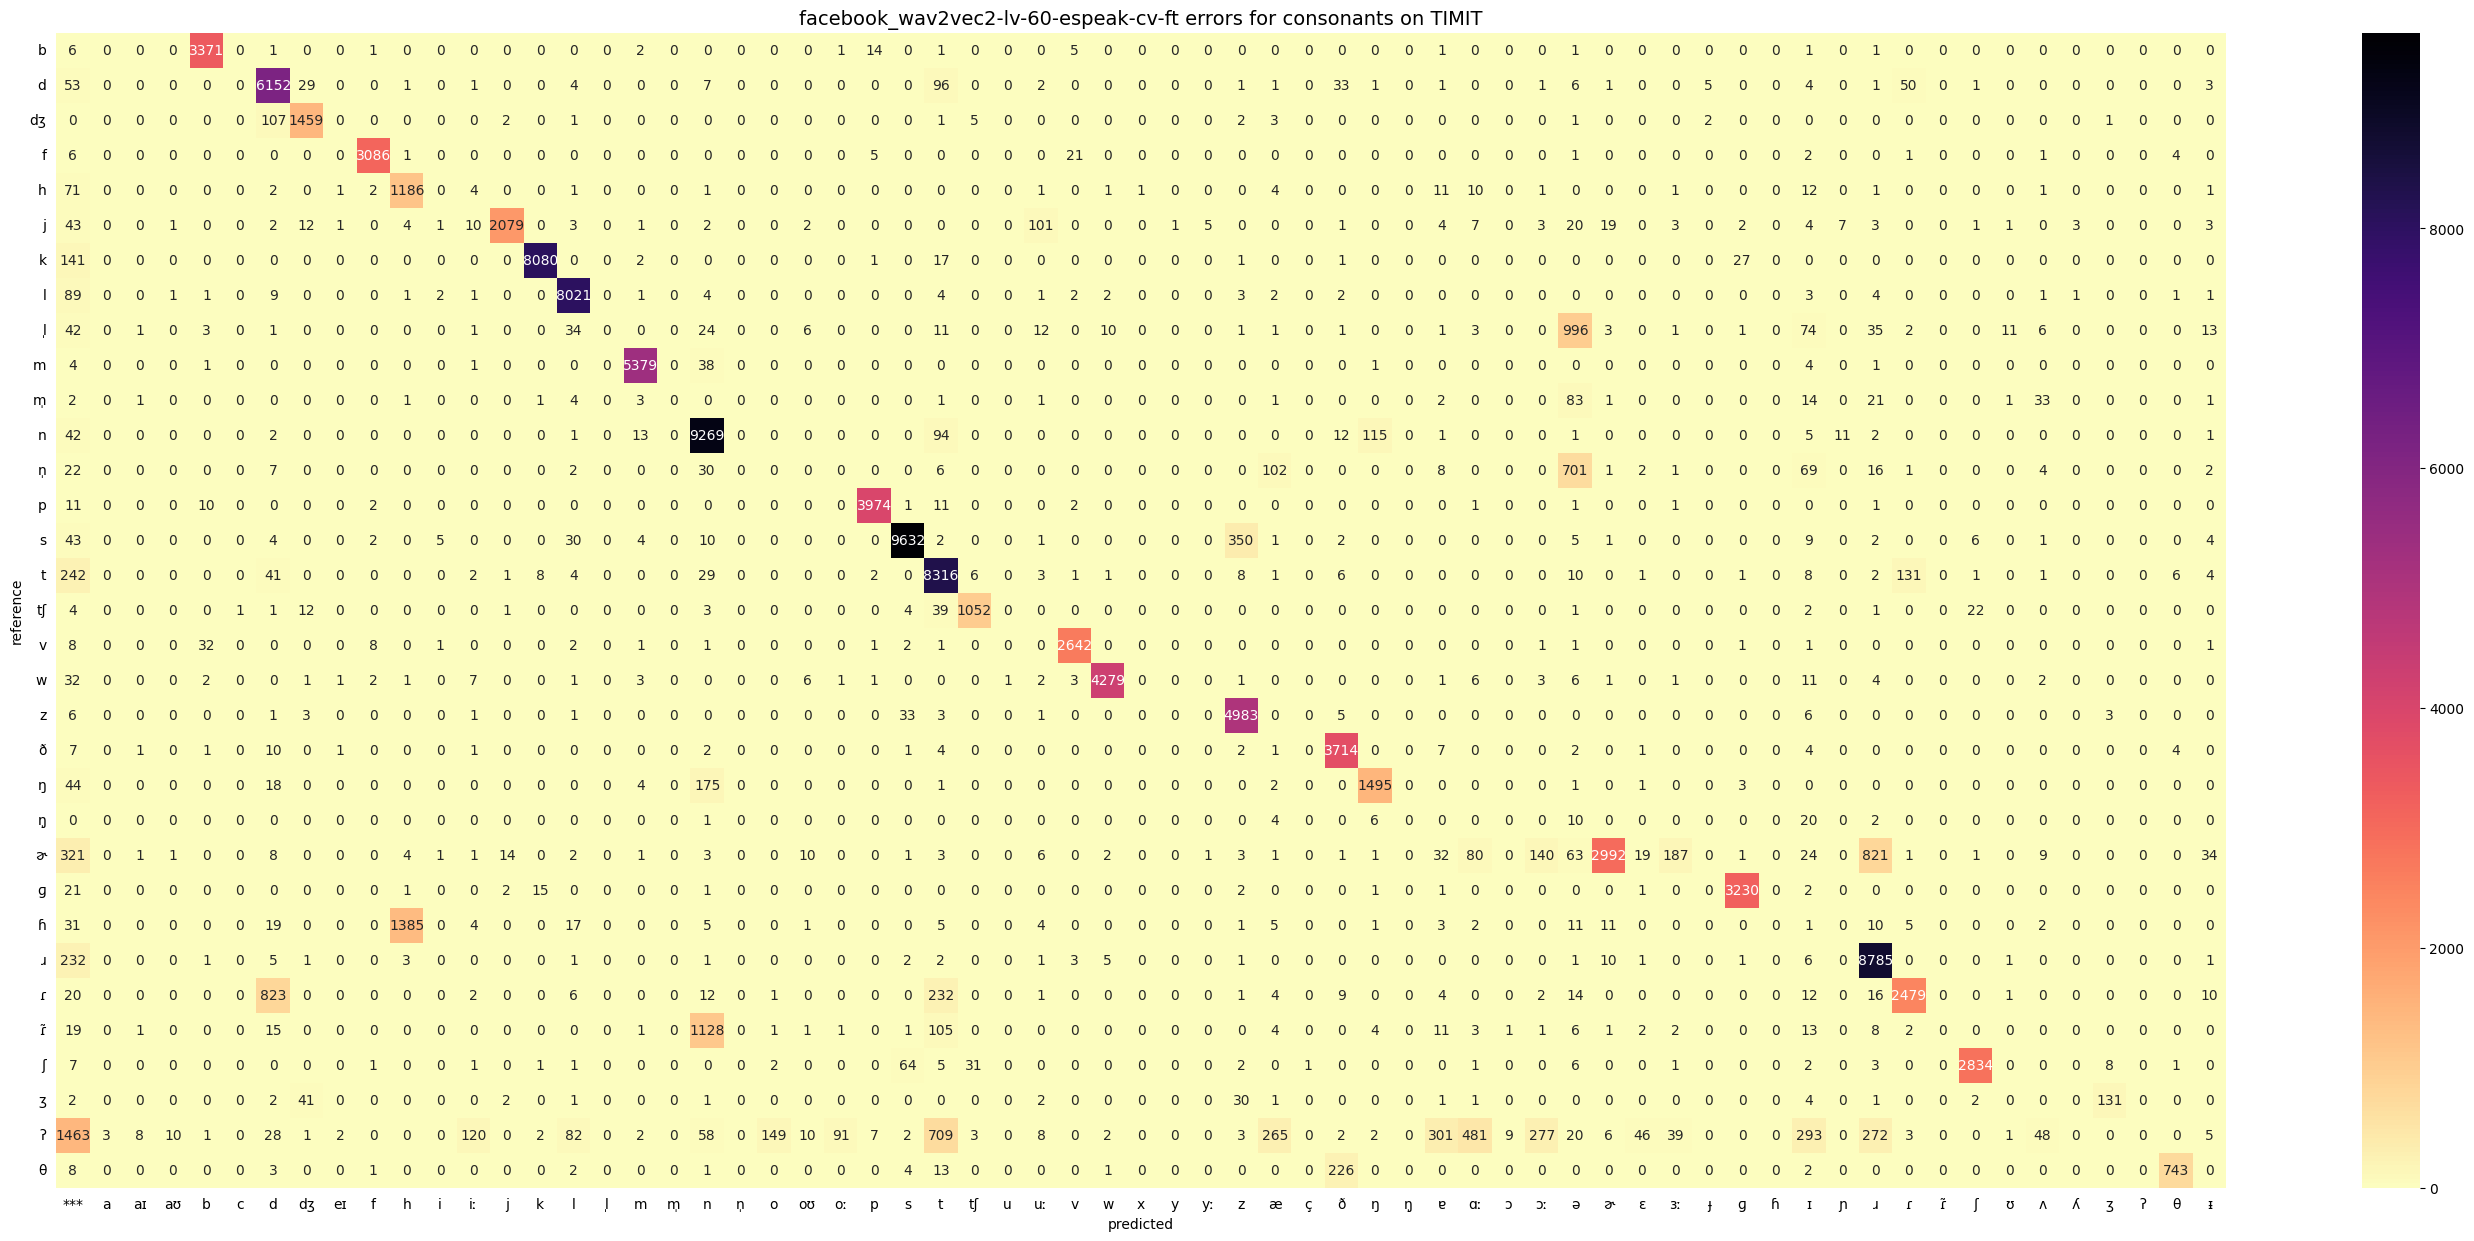

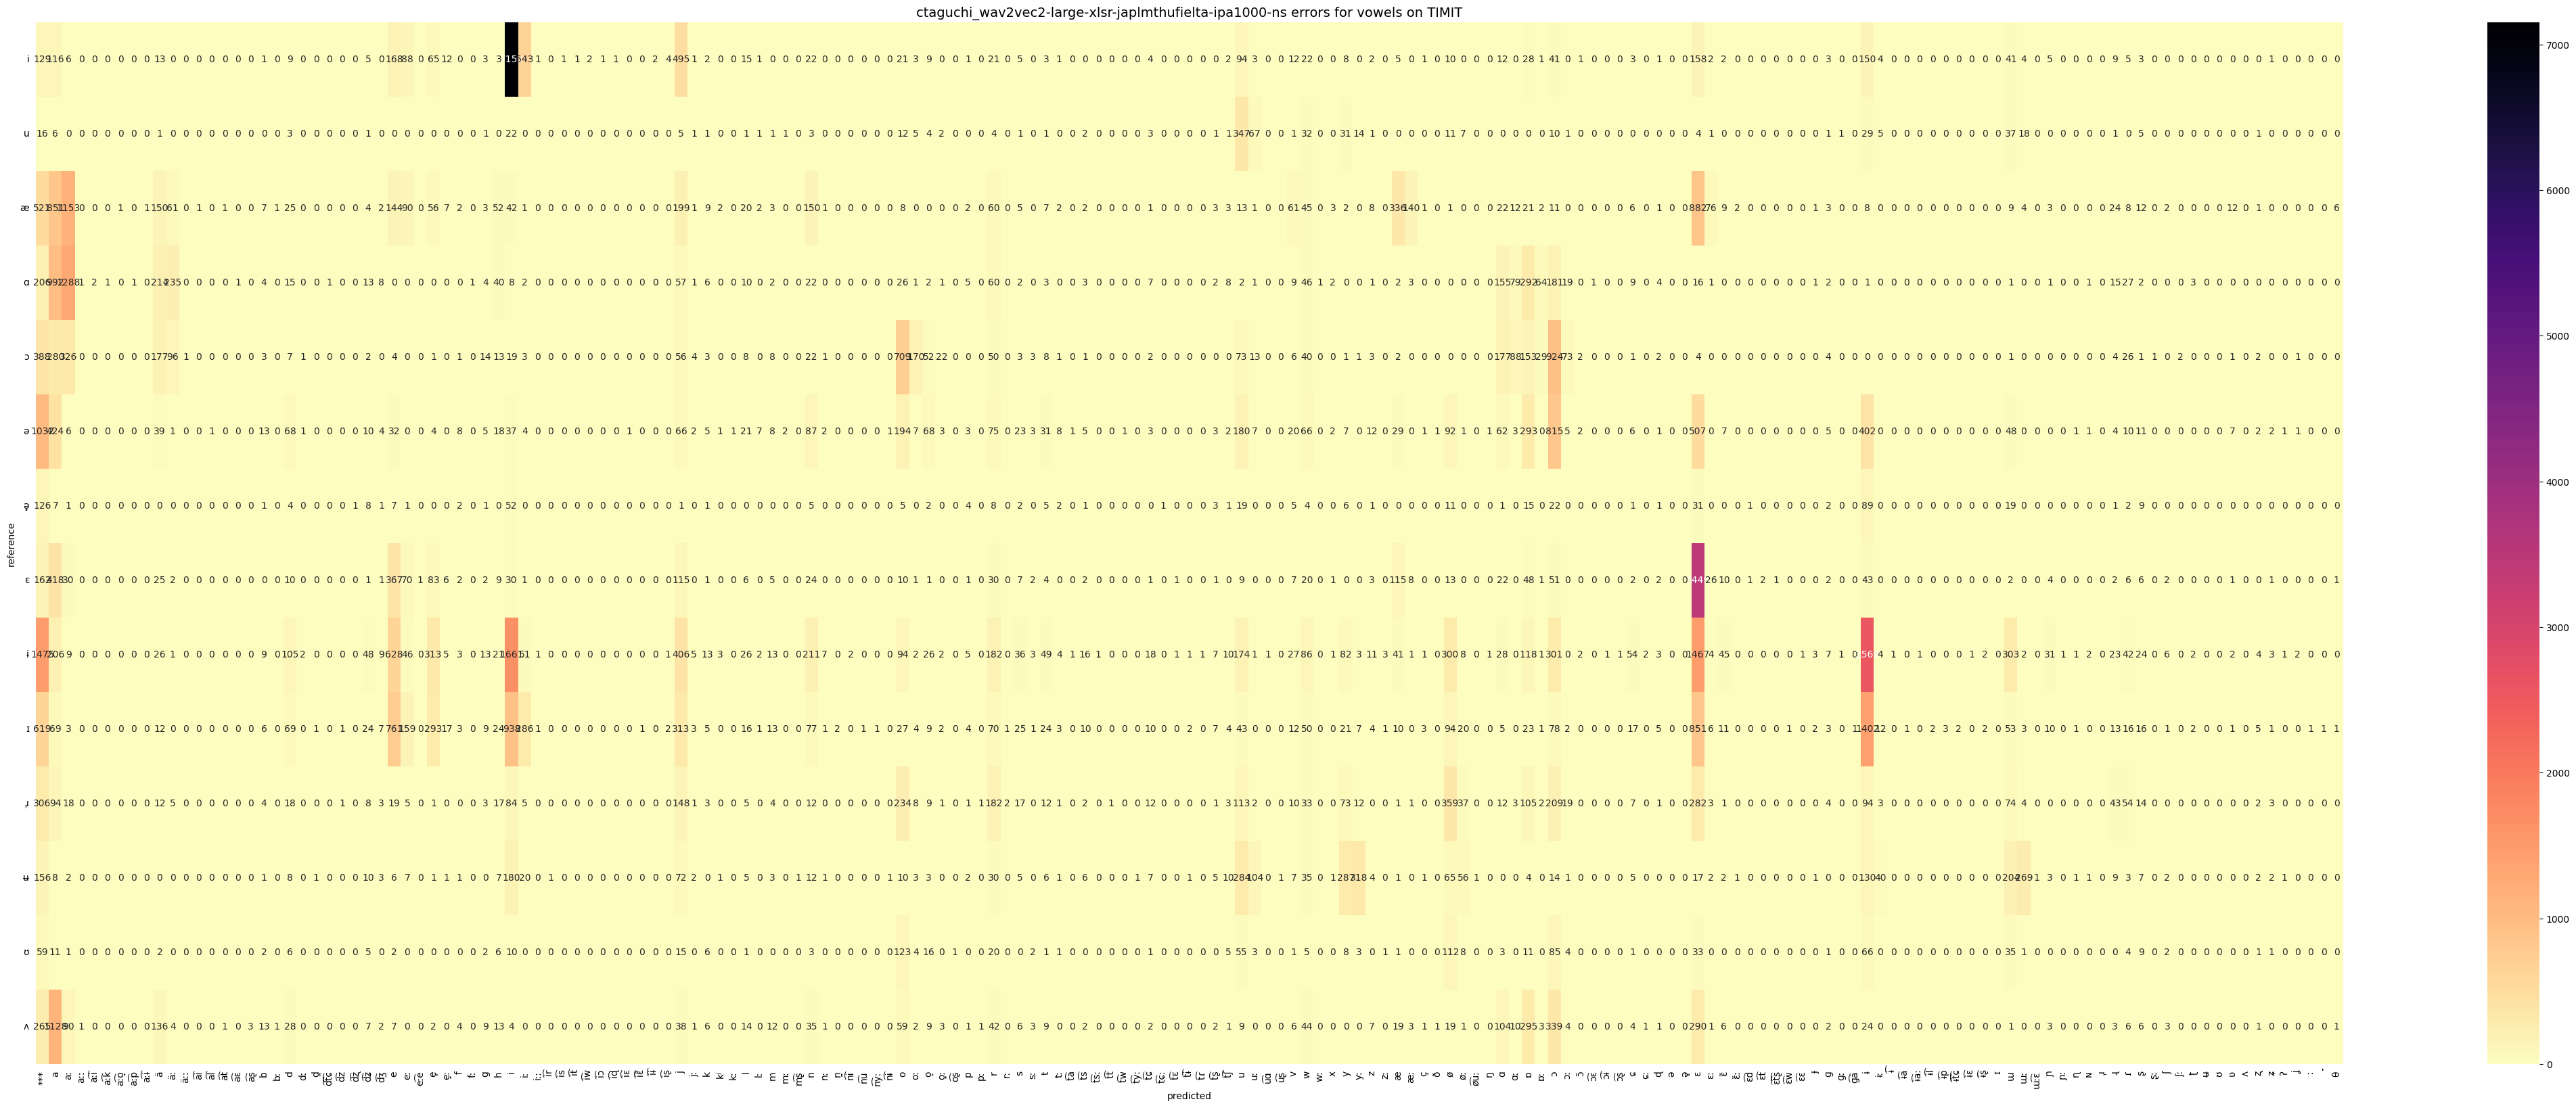

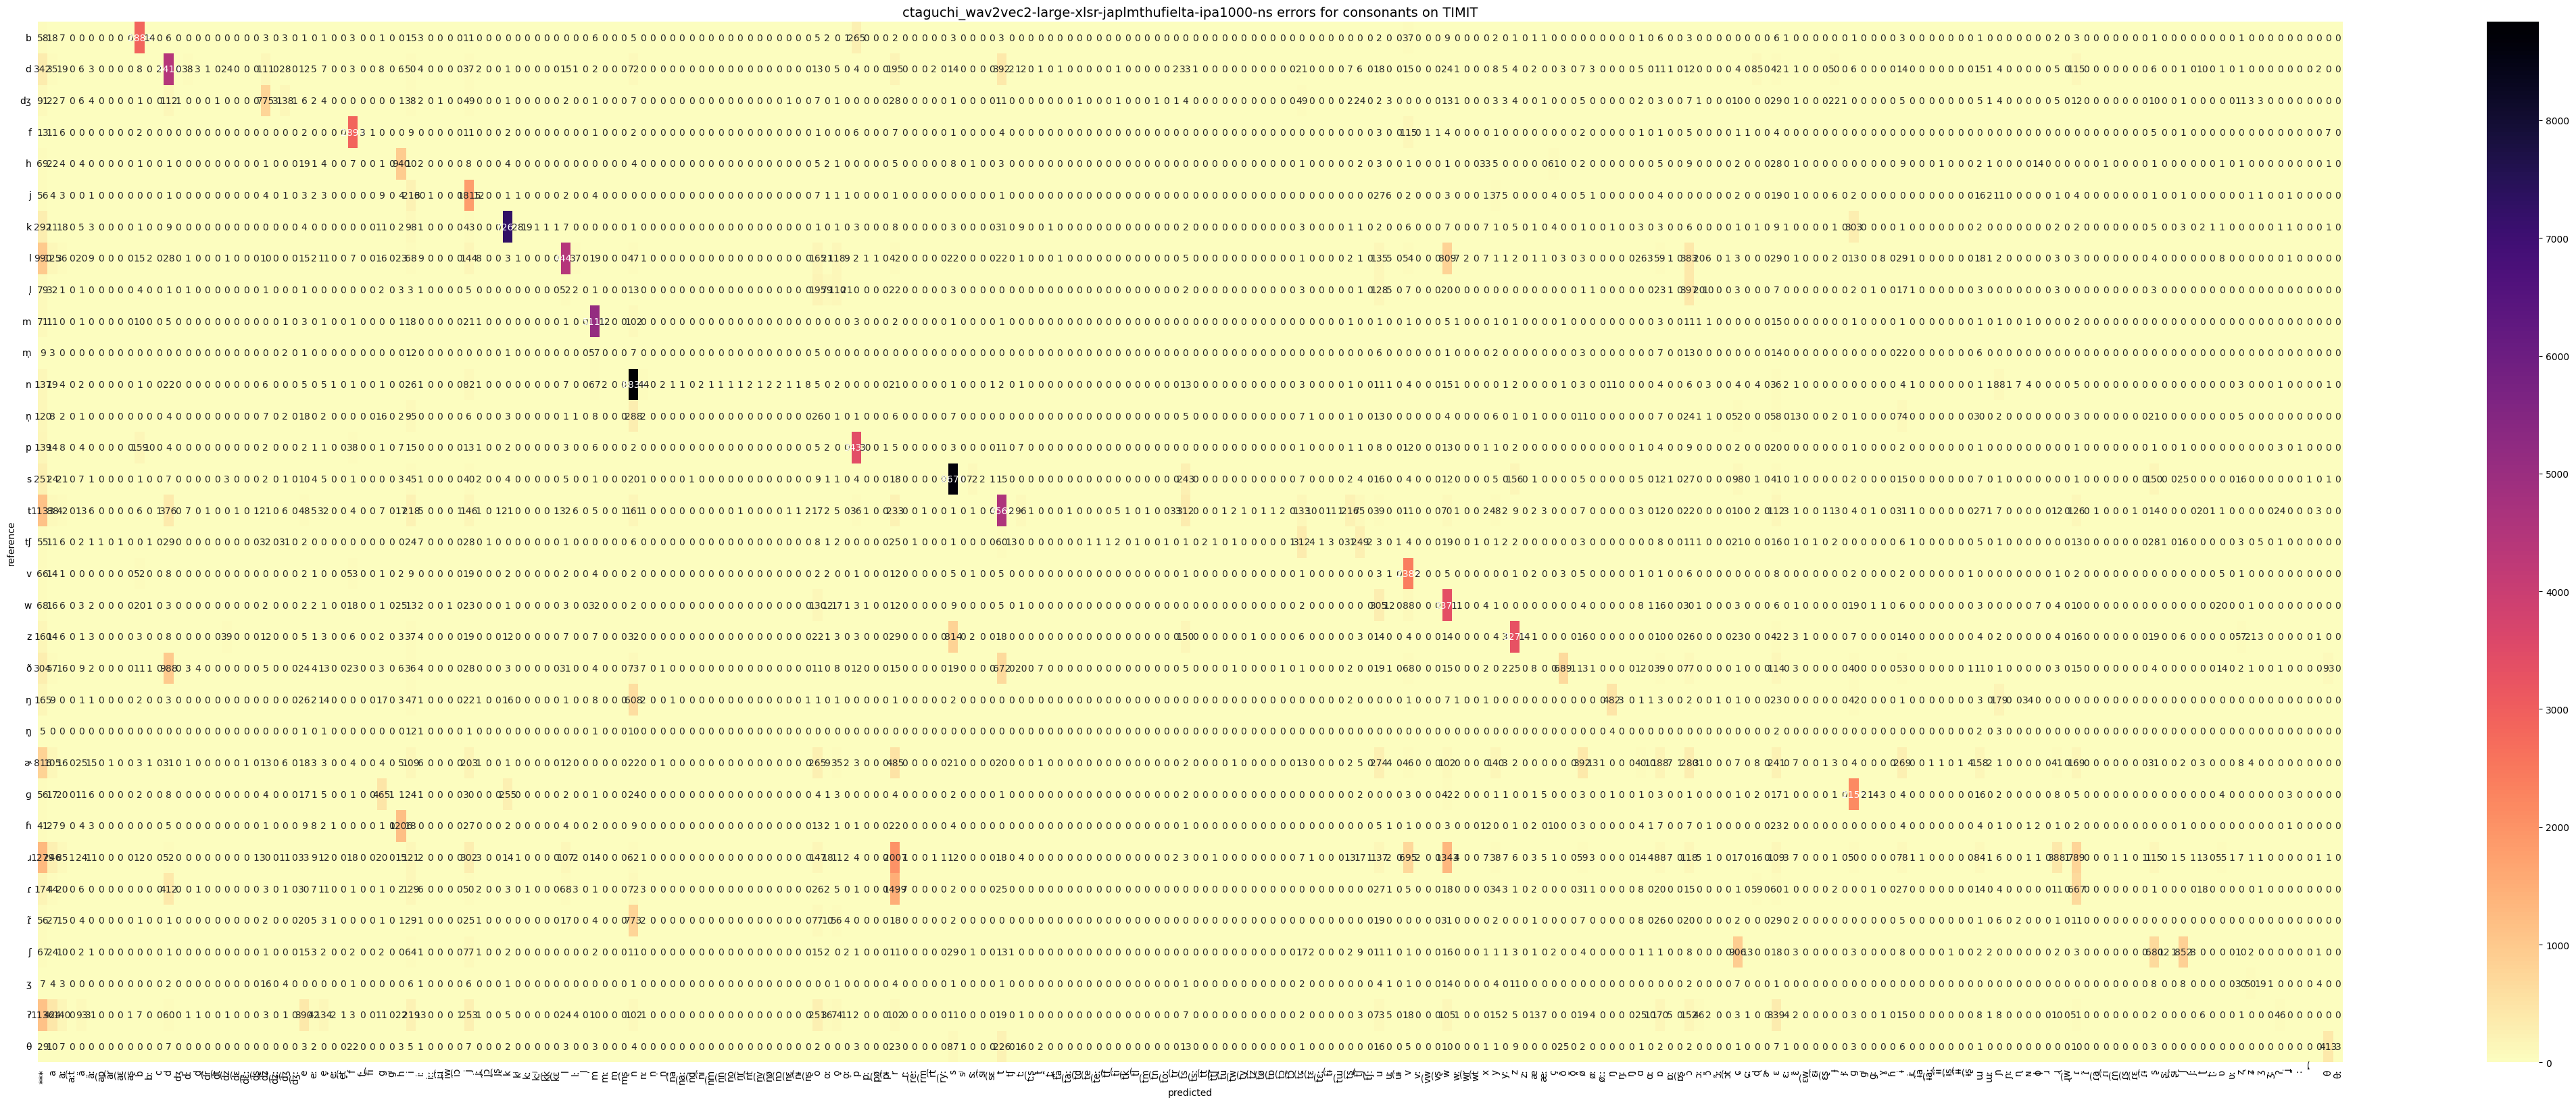

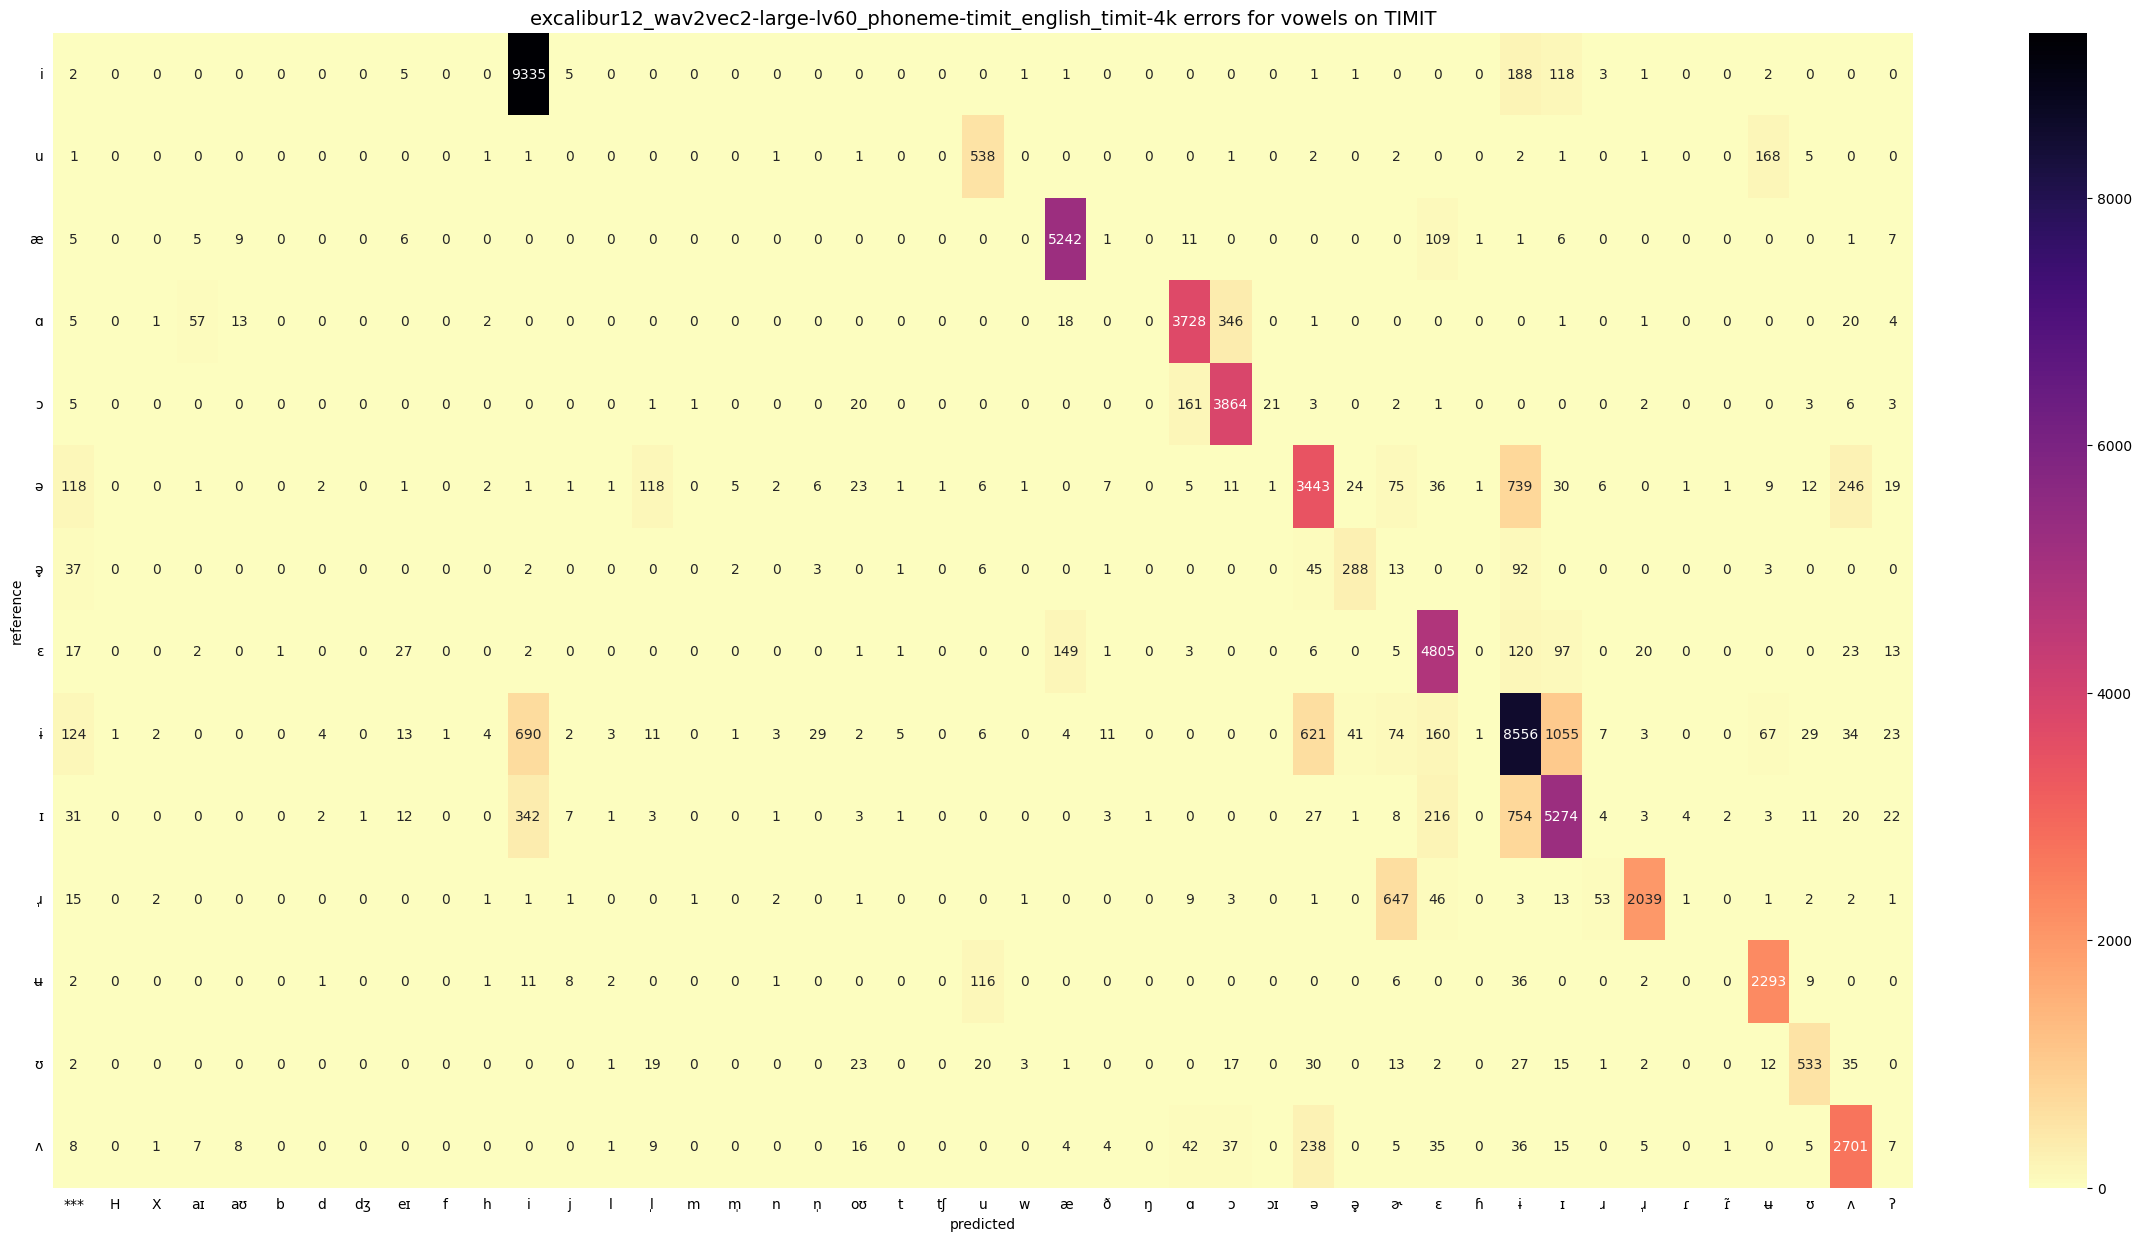

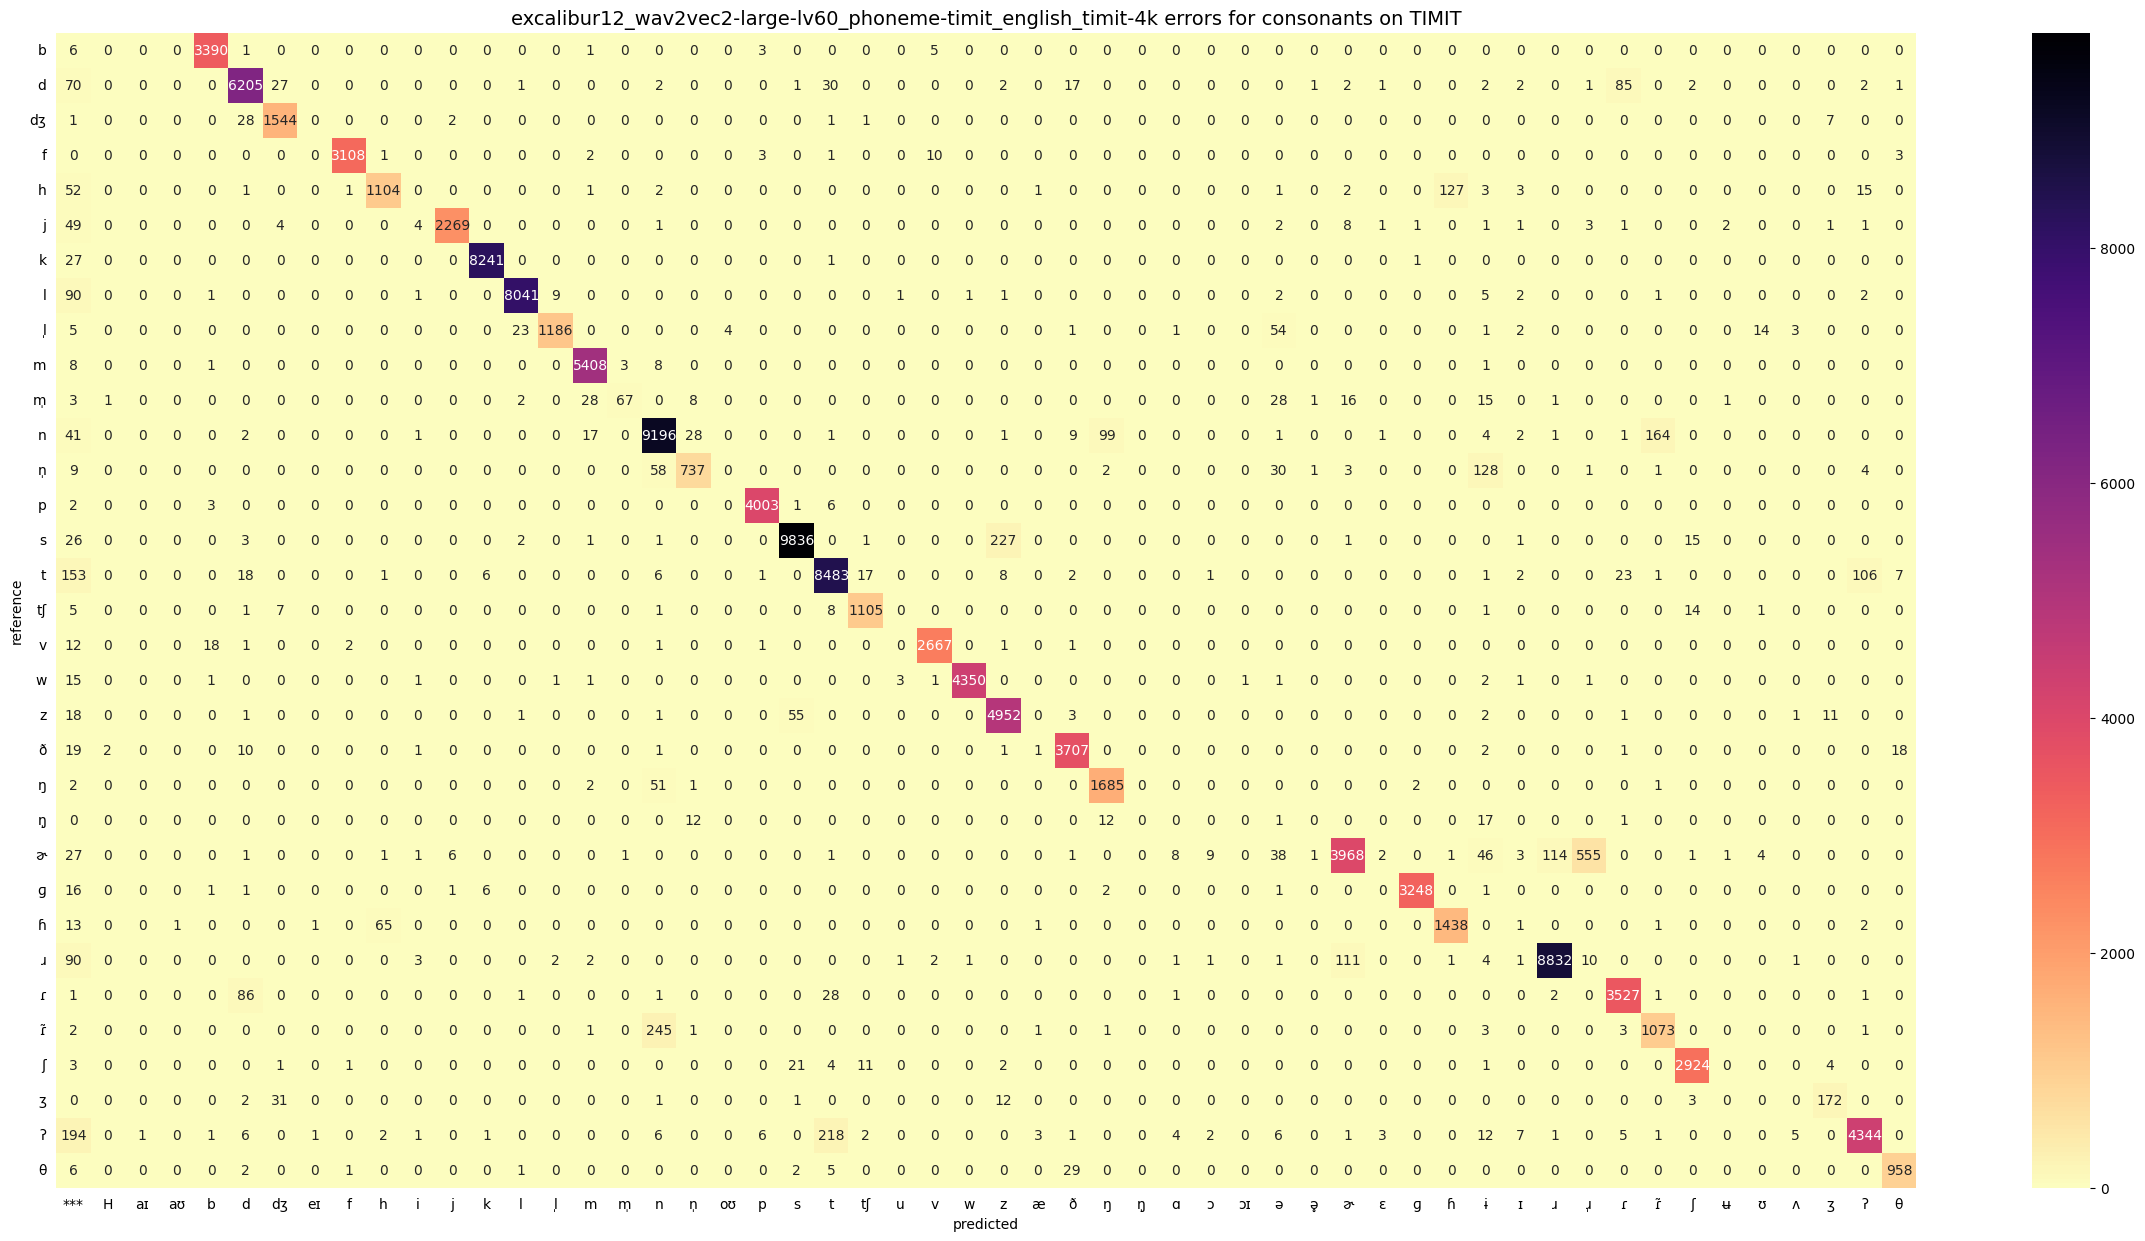

In [17]:
plt.clf()
desired_models_for_conf_matrix = [
    "full_dataset_train_3",
    "openai_whisper-medium.en_to_epitran",
    "allosaurus_eng2102_eng",
    "facebook_wav2vec2-lv-60-espeak-cv-ft",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
]
for mn in desired_models_for_conf_matrix:
    for (label, restriction) in [("vowels", TIMIT_VOWELS), ("consonants", TIMIT_CONSONANTS)]:
        if mn == "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns":
            figsize = (55, 20)
        elif mn ==    "facebook_wav2vec2-lv-60-espeak-cv-ft":
            figsize = (35, 15)
        else:
            figsize = (30,15)
        plot_token_confusion_matrix(conf_matrices[mn], f"{mn} errors for {label} on TIMIT", reference_keys=restriction, figsize=figsize, fmt='.0f', cmap="magma_r")

# Vocabulary item counts in pivot table
Get vocabulary item counts for each model and display them in a pivot table that helps you analyze differences between models. 

In [18]:
token_count_dfs = []
for model_name in desired_models_for_conf_matrix:
    matrix = conf_matrices[model_name]
    print("Model name:", model_name)
    token_count_df = matrix.groupby("predicted")["count"].sum().reset_index()
    token_count_df["model_name"] = model_name
    token_count_dfs.append(token_count_df)

full_token_count_df = pd.concat(token_count_dfs)
full_token_count_df = full_token_count_df[(full_token_count_df["count"] > 0) & (full_token_count_df["predicted"] != EPS)]
display(full_token_count_df.head())


Model name: full_dataset_train_3
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k


predicted  count            model_name
2        aɪ   2982  full_dataset_train_3
3        aʊ    868  full_dataset_train_3
4         b   3444  full_dataset_train_3
5         d   6727  full_dataset_train_3
6        dʒ   1577  full_dataset_train_3

In [19]:
token_count_pivoted = full_token_count_df.pivot(columns="model_name", index="predicted", values="count")
display(token_count_pivoted)

model_name  allosaurus_eng2102_eng  \
predicted                            
H                              NaN   
X                              NaN   
a                           4523.0   
aɪ                             2.0   
aʊ                             NaN   
aː                             NaN   
aːː                            NaN   
aː͡i                           NaN   
aː͡k                           NaN   
aː͡o̞                          NaN   
aː͡p                           NaN   
aː͡t                           NaN   
aː͡ɨ                           NaN   
ä                             NaN   
äː                            NaN   
äːː                           NaN   
a͡i                            NaN   
a͡l                            NaN   
a͡p                            NaN   
a͡r                            NaN   
a͡t                            NaN   
a͡ɛ                            NaN   
a͡ɨ                            NaN   
a͡ʂ                            NaN   
b                           3394.0   
bː                             NaN   
c                              NaN   
d                           8305.0   
dʒ                             NaN   
dː                             NaN   
d̪                             NaN   
d͡r                            NaN   
d͡t                            NaN   
d͡t͡ɕ                          NaN   
d͡z                            NaN   
d͡ɛ                            NaN   
d͡ɛ̃ː                          NaN   
d͡ʂ                            NaN   
d͡ʐ                            NaN   
d͡ʑ                            NaN   
d͡ʑː                           NaN   
d͡ʒ                         1289.0   
d͡ʒː                           NaN   
e                           3183.0   
eɪ                             9.0   
eː                             NaN   
eː͡e                           NaN   
e̞                             NaN   
e̞ː                            NaN   
e̞͡t                           NaN   
f                           3041.0   
fː                             NaN   
f͡i                            NaN   
g                              NaN   
gʲ                             NaN   
h                           2924.0   
i                           9675.0   
iː                             NaN   
iːː                            NaN   
iː͡i                           NaN   
ï                             NaN   
i͡r                            NaN   
i͡s                            NaN   
i͡t                            NaN   
i͡w                            NaN   
i͡ɔ                            NaN   
i͡ɖ                            NaN   
i͡ɛ                            NaN   
i͡ɛ̃                           NaN   
i͡ɨ                            NaN   
i͡ʂ                            NaN   
j                          10136.0   
jː                             NaN   
j͡ɔ                            NaN   
j͡ʂ                            NaN   
k                           8450.0   
kʲ                             NaN   
kː                             NaN   
kːʲ                            NaN   
k͡k                            NaN   
k͡ɛ                            NaN   
l                           9369.0   
lː                             NaN   
l̩                             NaN   
m                           5448.0   
mː                             NaN   
m̩                             NaN   
m͡ʂ                            NaN   
n                          12223.0   
nː                             NaN   
n̩                             NaN   
n̪                             NaN   
n͡a                            NaN   
n͡aː                           NaN   
n͡d                            NaN   
n͡i                            NaN   
n͡m                            NaN   
n͡n                            NaN   
n͡o                            NaN   
n͡r                            NaN   
n͡t                            NaN   
n͡u                            NaN   
n͡v                            NaN   
n͡yː      

In [20]:
token_count_pivoted.to_csv(TOKEN_ANALYSIS_OUTPUT)